# Extracting Spectra from NIRCam Grism data

### Taking FRESCO (GO-1895; PI: Oesch)  Data as an Example

<div align="right"> <b>Fengwu Sun</b> (Steward Observatory, University of Arizona, 2022) </div>
<div align="right">(Contact: <a href="mailto:fengwusun@arizona.edu">fengwusun[AT]arizona.edu</a>; Homepage: <a href="http://gxn.as.arizona.edu/~sunfengwu/home/">http://gxn.as.arizona.edu/~sunfengwu/home//</a>) </div>

<div align="right"> with significant help from Eiichi Egami (UofA), Nor Pirzkal (STScI) and Marcia Rieke (UofA) </div>

<div align="right">(v0 on July 16, 2022) </div>

<div align="right">(v1 on August 10, 2022) </div>

<div align="right">(v2 on October 21, 2022) </div>

<div align="right">(v3 on July 30, 2023) </div>

<br> 

Public PDF of APT File (PID 1895): [https://www.stsci.edu/jwst/phase2-public/1895.pdf](https://www.stsci.edu/jwst/phase2-public/1895.pdf) 

Reference to FRESCO Survey Design paper: [Oesch et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023arXiv230602466R/abstract)

<span style="color:red">If you find this notebook helpful and use it for your research, please cite <a href="https://ui.adsabs.harvard.edu/abs/2022arXiv220903374S/abstract">Sun et al. (2023), ApJ in press</a>.</span>

## A Short Overview:

In this notebook, we will go through the data reduction and spectral extraction pipeline of the JWST/NIRCam Wide-Field Slitless Spectroscopy (WFSS) mode. If you need basic introduction to this observation mode, I would recommend you to take a look of the [JDox Page on NIRCam/WFSS](https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-observing-modes/nircam-wide-field-slitless-spectroscopy). In this notebook, I assume that the potential users have basic knowledge of NIRCam and NIRCam grism, e.g.:
- There are two independent modules of NIRCam (module A and B);
- Each module has an instantaneous Field of View (FoV) of ~4.4 arcmin$^2$;
- There are two dispersion directions called R and C;
- The dispersion is around 1 nm/pix with a spectral resolution of R~1600 for point sources;
- When it is taking grism spectra at LW (2.4-5.0µm), the SW channel is taking direct imaging data.

Below is the flow chart for grism data analysis:

![flowchart](media/flowchart_grism.png)

In this image, all of the items enclosed in <span style="color:red">red boxes</span> are input fits files you download from MAST, which include (1) direct LW images, (2) direct SW images and (3) LW grism images. Starting from `*_rate.fits` files ([STScI pipeline stage-1 products](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html)), you can use direct images in LW and SW to produce final mosaics images and source catalogs (enclosed with <span style="color:green">green box</span>). These images and source catalogs can be very helpful for your target selections when extracting grism spectra. However, what you actually need to input for grism spectra extraction is (i) astrometric catalog that you want to register SW images onto, and (ii) coordinates (RA and DEC) of targets with interest. As long as you can register the astrometry of the LW grism images, using the spectral tracing models, grism dispersion models and flux calibration functions that I produced, you can extract calibrated 2D grism spectra for any sources you want. We will get to the point on how to do astrometric calibration and spectral calibration later in this notebook. 

## List of Content

1. [Import necessary modules and define functions](#1.-Import-necessary-python-modules)

2. [Getting the list of RATE.fits files](#2.-Get-list-of-RATE-files-(stage-1-products;-from-MAST))

3. [Reduce grism data to level-1.5 (e.g., assign wcs, flatfielding, bkgsubtraction)](#3.-Reduce-Grism-exposures-to-stage-level-1.5-(i.e.,-bkg-subtracted,-wcs-assigned))

4. [Characterize the astrometry of direct imaging in SW](#4.-Astrometry-Characterization-using-SW-Direct-imaging)

5. [Generating source catalog for each grism exposure](#5.-Genertae-Source-Catalog-for-each-LW-grism-exposure)

6. [2D Spectral extraction](#6.-2D-Spectral-Extraction)

7. [Examine 2D & 1D spectra in plots](#7.-Examine-2D-&-1D-spectra-in-plots)



### 1. Import necessary python modules

In [36]:
''' Astropy modules (I'm using astropy v5.1) '''
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.io import fits, ascii
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import MinMaxInterval, PercentileInterval, SqrtStretch, ImageNormalize, ZScaleInterval
from astropy import units as u
from astropy import constants as c
from astropy import wcs, table
from astropy.coordinates import SkyCoord
from astropy.table import Table, Column, vstack
from astropy.time import Time
from astropy.modeling.models import custom_model
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0 = 70, Om0 = 0.3)

''' Photutils modules (I'm using 1.5.0)'''
from photutils.detection import find_peaks, DAOStarFinder, IRAFStarFinder
from photutils import psf
from photutils.aperture import CircularAperture, aperture_photometry, CircularAnnulus, RectangularAperture, RectangularAnnulus
from photutils.background import Background2D, MedianBackground, SExtractorBackground
from photutils.segmentation import detect_sources, SourceFinder, SourceCatalog
### photutils background esitmator
sigma_clip = SigmaClip(sigma = 3.)
bkg_estimator = MedianBackground()

''' Numpy and Scipy modules '''
import numpy as np
from scipy import interpolate, integrate, optimize, stats, ndimage, signal

'''Matplotlib modules'''
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
from matplotlib.lines import Line2D
import matplotlib.animation as animation

%matplotlib inline

'''Some of the following modules are not used, remove if you cannot import'''
## finds all the pathnames matching a specified pattern
import glob   
## OS commands
import os
## subprocess with shell commands
import subprocess
## get time stamp
import time
## regular expression
import re
## download packadges? I guess I didn't use these:
# import urllib
# import requests
# import pkg_resources
## Belows are used by my legacy codes on grism simulation, maybe no need any more
# import h5py
# import yaml
# import copy

'''You might need some data from mirage simulator: 
       https://github.com/spacetelescope/mirage/
'''
# os.environ["MIRAGE_DATA"] = os.environ["MIRAGE_DATA"] + "/mirage_data/"
'''Import CRDS Server to environmental variable'''
os.environ["CRDS_SERVER_URL"]="https://jwst-cdrs.stsci.edu"

## Multiple processing
from multiprocessing import Pool, Lock
## https://github.com/npirzkal/GRISMCONF
import grismconf
## https://github.com/spacetelescope/pysiaf
import pysiaf 
## https://pypi.org/project/asdf/
import asdf

## if there is any animation to be display with Jupyter notebook:
from IPython.display import HTML

'''Filter some warning'''
import warnings
warnings.filterwarnings("ignore", message="'obsfix' made the change")
warnings.filterwarnings("ignore", message="'datfix' made the change")
warnings.filterwarnings("ignore", message = "Card is too long")
warnings.filterwarnings("ignore", message = "divide by zero")
warnings.filterwarnings("ignore", message = "invalid value encountered")
warnings.filterwarnings("ignore", message = "Input data contains invalid values")


'''Default nircam zeropoint with native pixel size in LW (0.0629 arcsec/pixel)'''
nircam_LW_ZP = -2.5 * np.log10((u.MJy / u.sr * (0.0629*u.arcsec)**2 / (3631 * u.Jy)).cgs.value)

In [37]:
'''
Matplotlib Drawing:
'''
plt.rcParams.update({'font.size': 16})  ## larger font size

def get_corner_pos(ax, loc = 1, edge = 0.02):
    '''get (x, y) for the corner of an axes at given quadrant (1, 2, 3, 4)'''
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xscale, yscale = ax.get_xscale(), ax.get_yscale()
    if loc not in [1, 2, 3, 4]: raise ValueError('The parameter `loc` must be 1 or 2 or 3 or 4.')
    vec_edge = np.array([1-edge, edge])
    vec_x = np.array([[xlim[1], xlim[0], xlim[0], xlim[1]][loc-1], [xlim[0], xlim[1], xlim[1], xlim[0]][loc-1]])
    vec_y = np.array([[ylim[1], ylim[1], ylim[0], ylim[0]][loc-1], [ylim[0], ylim[0], ylim[1], ylim[1]][loc-1]])
    if xscale == 'linear': x_text = np.dot(vec_edge, vec_x)
    else: x_text = 10 ** np.dot(vec_edge, np.log10(vec_x))
    if yscale == 'linear': y_text = np.dot(vec_edge, vec_y)
    else: y_text = 10 ** np.dot(vec_edge, np.log10(vec_y))
    return (x_text, y_text)

def corner_text(ax, s ='', loc = 1, edge = 0.02, **kwargs):
    '''Add text at the corner of an axes'''
    if loc not in [1, 2, 3, 4]: raise ValueError('The parameter `loc` must be 1 or 2 or 3 or 4.')
    ha = ['right', 'left', 'left', 'right']
    va = ['top', 'top', 'bottom', 'bottom']
    return ax.text(*get_corner_pos(ax, loc, edge), s=s, ha = ha[loc-1], va = va[loc-1], **kwargs)

def rotate(axis, angle):
    '''Fundamental rotation matrices.
    Rotate by angle measured in degrees, about axis 1 2 or 3'''
    if axis not in list(range(1, 4)):
        print ('Axis must be in range 1 to 3')
        return
    r = np.zeros((3, 3))
    ax0 = axis-1 #Allow for zero offset numbering
    theta = angle * np.pi / 180. # radians(angle)
    r[ax0, ax0] = 1.0
    ax1 = (ax0+1) % 3
    ax2 = (ax0+2) % 3
    r[ax1, ax1] = np.cos(theta)
    r[ax2, ax2] = np.cos(theta)
    r[ax1, ax2] = - np.sin(theta)
    r[ax2, ax1] = np.sin(theta)
    return r

def attitude(v2, v3, ra, dec, pa):
    '''This will make a rotation matrix which rotates a unit vector representing a v2, v3 position
    to a unit vector representing an RA, Dec pointing with an assigned position angle
    Described in JWST-STScI-001550, SM-12, section 6.1'''
    # v2, v3 in arcsec, ra, dec and position angle in degrees
    v2d = v2/3600.0
    v3d = v3/3600.0

    # Get separate rotation matrices
    mv2 = rotate(3, -v2d)
    mv3 = rotate(2, v3d)
    mra = rotate(3, ra)
    mdec = rotate(2, -dec)
    mpa = rotate(1, -pa)

    # Combine as mra*mdec*mpa*mv3*mv2
    m = np.dot(mv3, mv2)
    m = np.dot(mpa, m)
    m = np.dot(mdec, m)
    m = np.dot(mra, m)

    return m

'''This is the Grism Dispersion function, will be detailed later'''
def fit_disp_order32(data, 
                     a01, a02, a03, a04, a05, a06, 
                     b01, b02, b03, b04, b05, b06, 
                     c01, c02, c03, #c04, c05, c06,
                     d01, #d02, d03, d04, d05, d06,
                    ):
    ## data is an numpy array of the shape (3, N)
    ##     - data[0]:  x_pixel      --> fit with second-degree polynomial
    ##     - data[1]:  y_pixel      --> fit with second-degree polynomial
    ##     - data[2]:  wavelength   --> fit with third-degree polynomial
    xpix, ypix, dx = data[0] - 1024, data[1] - 1024, data[2] - 3.95
    ## return dx = dx(x_pixel, y_pixel, lambda)
    return ((a01 + (a02 * xpix + a03 * ypix) + (a04 * xpix**2 + a05 * xpix * ypix + a06 * ypix**2)
            ) + 
            (b01 + (b02 * xpix + b03 * ypix) + (b04 * xpix**2 + b05 * xpix * ypix + b06 * ypix**2)
            ) * dx +
            (c01 + (c02 * xpix + c03 * ypix) #+ (c04 * xpix**2 + c05 * xpix * ypix + c06 * ypix**2)
            ) * dx**2 + 
            (d01 #+ (d02 * xpix + d03 * ypix) + (d04 * xpix**2 + d05 * xpix * ypix + d06 * ypix**2)
            ) * dx**3
           ) 

func_fit_wave = fit_disp_order32


'''This is the Spectral Tracing function, will be detailed later'''
def fit_disp_order23(data, 
                     a01, a02, a03, a04, a05, a06, a07, a08, a09, a10,
                     b01, b02, b03, b04, b05, b06, b07, b08, b09, b10,
                     c01, c02, c03, c04, c05, c06, c07, c08, c09, c10,
                    ):
    ## data is an numpy array of the shape (3, N)
    ##     - data[0]:  x_pixel  --> fit with second-degree polynomial
    ##     - data[1]:  y_pixel  --> fit with second-degree polynomial
    ##     - data[2]:  dx     --> fit with second-degree polynomial
    xpix, ypix, dx = data[0] - 1024, data[1] - 1024, data[2]
    ## return dy = dy(x_pixel, y_pixel, d_x)
    return ((a01 + (a02 * xpix + a03 * ypix) + (a04 * xpix**2 + a05 * xpix * ypix + a06 * ypix**2)
             + (a07 * xpix**3 + a08 * xpix**2 * ypix + a09 * xpix * ypix**2 + a10 * ypix**3)
            ) + 
            (b01 + (b02 * xpix + b03 * ypix) + (b04 * xpix**2 + b05 * xpix * ypix + b06 * ypix**2)
             + (b07 * xpix**3 + b08 * xpix**2 * ypix + b09 * xpix * ypix**2 + b10 * ypix**3)
            ) * dx +
            (c01 + (c02 * xpix + c03 * ypix) + (c04 * xpix**2 + c05 * xpix * ypix + c06 * ypix**2)
             + (c07 * xpix**3 + c08 * xpix**2 * ypix + c09 * xpix * ypix**2 + c10 * ypix**3)
            ) * dx**2
           ) 


def grism_conf_preparation(x0 = 1024, y0 = 1024, pupil = 'R', 
                           fit_opt_fit = np.zeros(30), w_opt = np.zeros(16)):
    '''
    Prepare grism configuration, dxs, dys, wavelengths based on input (x0, y0) pixel postion
        and filter/pupil/module information.
    -----------------------------------------------
        Parameters
        ----------  
        x0, y0 : float
            Reference position (i.e., in direct image)
        
        pupil: 'R' or 'C'
            pupil of grism ('R' or 'C')
        
        fit_opt_fit: numpy.ndarray, shape: (30,)
            polynomial parameters in the perpendicular direction, used by function `fit_disp_order23` 
        
        w_opt: numpy.ndarray, shape: (16,)
            polynomial parameters in the dispersed direction, used by function `fit_disp_order32` 
        
        Returns
        -------
        
        dxs, dys : `~numpy.ndarray`
            offset of spectral pixel from the direct imaging position
        
        wavs: `~numpy.ndarray`
            Array of wavelengths corresponding to dxs and dys
    '''
    # Load the Grism Configuration file
    # GConf = grismconf.Config(os.environ['MIRAGE_DATA'] + "/nircam/GRISM_NIRCAM/V3/" +
    #                          "NIRCAM_%s_mod%s_%s.conf" % (filter, module, pupil))
    wave_space = np.arange(2.39, 5.15, 0.01)
    disp_space = func_fit_wave(np.vstack((x0 * np.ones_like(wave_space), y0 * np.ones_like(wave_space), wave_space)), *w_opt)
    inverse_wave_disp = interpolate.UnivariateSpline(disp_space[np.argsort(disp_space)], wave_space[np.argsort(disp_space)], s = 0, k = 1)

    if pupil == 'R':
        dxs = np.arange(int(np.min(disp_space)), int(np.max(disp_space))) - x0%1
        # Compute wavelength of each of the pixels
        wavs = inverse_wave_disp(dxs)
        # Compute the dys values for the same pixels
        dys = fit_disp_order23(np.vstack((x0* np.ones_like(dxs), y0 * np.ones_like(dxs), dxs)), *fit_opt_fit)
        # dxs = np.arange(-1800, 1800, 1) - x0%1
        ## Compute the t values corresponding to the exact offsets (with old grism config)
        # ts = GConf.INVDISPX(order = '+1', x0 = x0, y0 = y0, dx = dxs)
        # dys = GConf.DISPY('+1', x0, y0, ts)
        # wavs = GConf.DISPL('+1', x0, y0, ts)
        # tmp_aper = np.max([0.2, 1.5 * tmp_re_maj * np.cos(tmp_pa), 1.5 * tmp_re_min * np.sin(tmp_pa)])
    elif pupil == 'C':
        # Compute the dys values for the same pixels
        dys = np.arange(int(np.min(disp_space)), int(np.max(disp_space))) - y0%1
        # Compute wavelength of each of the pixels
        wavs = inverse_wave_disp(dys)
        dxs = fit_disp_order23(np.vstack((x0* np.ones_like(dys), y0 * np.ones_like(dys), dys)), *fit_opt_fit)
        # dys = np.arange(-1800, 1800, 1) - y0%1
        ## Compute the t values corresponding to the exact offsets (with old grism config)
        # ts = GConf.INVDISPY(order = '+1', x0 = x0, y0 = y0, dy = dys)
        # dxs = GConf.DISPX('+1', x0, y0, ts)
        # wavs = GConf.DISPL('+1', x0, y0, ts)
    return (dxs, dys, wavs)

'''Lienar Function'''
linear = lambda x, k, b: x * k + b
'''gaussian function'''
gauss = lambda x, x0, flux, FWHM : (flux / FWHM / 1.064467) * np.exp(-(x - x0)**2 / (2 * (FWHM/2.354820)**2))
'''gaussian function + continuum'''
gauss_cont_prof = lambda x, x0, flux, FWHM, k, b : (flux / FWHM / 1.064467) * np.exp(-(x - x0)**2 / (2 * (FWHM/2.354820)**2)) + k * (x - 1024) + b

Not all of the source in your input catalog could yield spectra on your 2D grism image. For example, below is the spectral coverage for F444W grism-R in module A and B (that is being used by FRESCO):

![F444W Grism-R Coverage](media/FSun_tracing_FoV_CS_PS_F444W_grismR.png)

In this plot, everything is in the detector frame (X and Y; e.g., the detector range is X=0-2047, Y=0-2047 which is indicated by the red box). Based on pre-launch estimate, the regions that can be perfectly picked off by the POM are shown in shallow grey color, and the coronagraph regions are in white - usally the spectral quality will be affected if your source falls in these regions. **Only sources in the blue (module-A) and orange (module-B) can yield complete spectra with the current filter setting (F444W)**. The pre-launch estimate of full spectral coverage region is indicated by the black boxes, so you can see some differences. The yielded spectra alongside with the dispersion directions are indicated by the arrows. If the source falls in the hatched region, it could yield partial spectral coverage. You can get access to all of the spectral coverage plots of all NIRCam LW filters and grisms at [http://gxn.as.arizona.edu/~sunfengwu/home/data/spectral_cov/](http://gxn.as.arizona.edu/~sunfengwu/home/data/spectral_cov/).

#### The following codes are used to check whether the source could enter Pick-Off Mirror (POM) and yield spectrum:


In [38]:
## module A/B LW POM transmission:
##     These files can be downloaded at: https://github.com/npirzkal/GRISM_NIRCAM/tree/master/V4
modA_LW_POM_fits = fits.open('data/GRISM_NIRCAM/NIRCAM_LW_POM_ModA_trans.fits')
modB_LW_POM_fits = fits.open('data/GRISM_NIRCAM/NIRCAM_LW_POM_ModB_trans.fits')
modA_LW_POM_trans = modA_LW_POM_fits[1].data # np.clip(np.int8(modA_LW_POM_fits[1].data), 0, 1)
modB_LW_POM_trans = modB_LW_POM_fits[1].data # np.clip(np.int8(modB_LW_POM_fits[1].data), 0, 1)
xy_start_POM_modA = modA_LW_POM_fits[1].header['NOMXSTRT'], modA_LW_POM_fits[1].header['NOMYSTRT'] 
xy_start_POM_modB = modB_LW_POM_fits[1].header['NOMXSTRT'], modA_LW_POM_fits[1].header['NOMYSTRT'] 

def is_pickoff(x, y, module = 'A'):
    '''
    Input x/y pixel(s) and module, find whether the source will be picked off by NIRCam POM.
    '''
    ### get module and start point
    if module.upper() == 'A': xy_start, POM_trans = xy_start_POM_modA, modA_LW_POM_trans
    elif module.upper() == 'B': xy_start, POM_trans = xy_start_POM_modB, modB_LW_POM_trans
    else: raise ValueError("Only \"A\" or \"B\" is allowed for module.")
    if type(x) == np.ndarray: tmp_x, tmp_y = np.int32(x), np.int32(y)
    elif type(x) == list: tmp_x, tmp_y = np.array(x, dtype = np.int32), np.array(y, dtype = np.int32)
    elif type(x) == int: tmp_x, tmp_y = np.array([x], dtype = np.int32), np.array([y], dtype = np.int32) 
    elif type(x) == float: tmp_x, tmp_y = np.array([x], dtype = np.int32), np.array([y], dtype = np.int32) 
    else: raise TypeError("Only integers/floats or their list/np.array() are allowed.")
    if len(tmp_x) != len(tmp_y): raise ValueError("x, y list should be of the same length.")
    tmp_x = tmp_x + xy_start[0]
    tmp_y = tmp_y + xy_start[1]
    arr_trans = []
    for j in range(len(tmp_x)):
        if (tmp_x[j] < 0)|(tmp_y[j]<0)|(tmp_x[j] > POM_trans.shape[1]-1)|(tmp_y[j] > POM_trans.shape[0]-1):
            arr_trans.append(0) 
        else:
            arr_trans.append(POM_trans[tmp_x[j], tmp_x[j]])
    return np.array(arr_trans, dtype = int)

def is_pickoff_PS(x, y, module = 'A', filter = 'F444W', pupil = 'R'):
    '''
    Input x/y pixel(s) and module, 
    find whether the source will be picked off by NIRCam POM and yield partial/complete spectra.
    '''
    ### Get module and start point:
    ##  partial spectral coverage region fits files (`path_PS`) can be downloaded at: 
    ##         http://gxn.as.arizona.edu/~sunfengwu/spec_cov/
    ## now available for both wide and medium LW filter now.
    path_PS  = 'data/FSun_cal/FSun_SpecCov_%s_%s_%s.fits' % (filter, module, pupil)
    path_POM = 'data/GRISM_NIRCAM//NIRCAM_LW_POM_Mod%s_trans.fits' % module
    if os.path.isfile(path_PS) == False: 
        raise FileNotFoundError("Spectral Coverage file %s not found!" % path_PS)
    # if os.path.isfile(path_POM) == False: 
    #     raise FileNotFoundError("POM Coverage file %s not found!" %path_POM)
    spec_cov_fits = fits.open(path_PS)
    xy_start = (spec_cov_fits[0].header['NOMXSTRT'], spec_cov_fits[0].header['NOMYSTRT'])
    POM_trans = spec_cov_fits[0].data # * np.int16(fits.getdata(path_POM) == 1)
    spec_cov_fits.close()
    if type(x) == np.ndarray: tmp_x, tmp_y = np.int32(x), np.int32(y)
    elif type(x) == list: tmp_x, tmp_y = np.array(x, dtype = np.int32), np.array(y, dtype = np.int32)
    elif type(x) == int:  tmp_x, tmp_y = np.array([x], dtype = np.int32), np.array([y], dtype = np.int32) 
    elif type(x) == float: tmp_x, tmp_y = np.array([x], dtype = np.int32), np.array([y], dtype = np.int32) 
    else: raise TypeError("Only integers/floats or their list/np.array() are allowed.")
    if len(tmp_x) != len(tmp_y): raise ValueError("x, y list should be of the same length.")
    tmp_x = tmp_x + xy_start[0]
    tmp_y = tmp_y + xy_start[1]
    arr_trans = []
    for j in range(len(tmp_x)):
        if (tmp_x[j] < 0)|(tmp_y[j]<0)|(tmp_x[j] > POM_trans.shape[1]-1)|(tmp_y[j] > POM_trans.shape[0]-1):
            arr_trans.append(0) 
        ### For now, I don't trust the spectra from Coronagraphy region (y >~ 2250); 
        ### I'm masking all of these frames:
        elif tmp_y[j] > 2250:
            arr_trans.append(0)
        else:
            arr_trans.append(POM_trans[tmp_y[j], tmp_x[j]])
    return np.array(arr_trans, dtype = float)

### 2. Get list of RATE files (stage-1 products; from MAST)

We will make use of FRESCO observation number-001 (i.e., observations in the GOODS-S field) as an example of data reduction. This notebook starts from the `_rate.fits` files of grism exposures & direct imaging exposures associated with grism, both of which can be directly downloaded from MAST [https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html). You can also download `*_uncal.fits` and reduce them with [the JWST stage-1 pipeline](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_detector1.html) to produce `*_rate.fits` files. For your simplicity, I have prepared two bash script that you can use them to download the `*_rate.fits` files with MAST data-product API:

| Type of data | Link|
|-|-|
| GOODS-S (obs001), LW grism exposure in F444W | [http://gxn.as.arizona.edu/~sunfengwu/grism_demo/download_fresco_grism_F444W_001.sh](http://gxn.as.arizona.edu/~sunfengwu/grism_demo/download_fresco_grism_F444W_001.sh)|
| GOODS-S (obs001), SW direct imaging data in the F182M/F210M filter that are associated with grism exposures | [http://gxn.as.arizona.edu/~sunfengwu/grism_demo/download_fresco_direct_imaging_001.sh](http://gxn.as.arizona.edu/~sunfengwu/grism_demo/download_fresco_direct_imaging_001.sh) |

**Note:** The size of NIRCam `rate.fits` file is typically 81MB, which means the two download script will download **~10GB and ~40GB data**, respectively. Make sure that you have enough disk space. You can run the following command in your terminal to download the data:

```
bash download_fresco_grism_F444W_001.sh
```

and

```
bash download_fresco_direct_imaging_001.sh
```

you can get a list of the rate files and start analyzing the observational setups (e.g., filter, module, pupil, targets) of these observations:


In [39]:
'''
List of the rate files on your local directory:
    Here I'm only selecting module A/B long wavelength grism images by wildcards: `jw*nrc[a-b]long_rate`
'''
#### This the path of the files that I downloaded, change your path!
list_rate = np.array(glob.glob('/xdisk/egami/fengwusun/grism_demo/grism_F444W/jw*nrc[a-b]long_rate.fits'))


list_rate.sort()

'''List of filter, pupil, module, target, exposure time, etc.'''
list_filter = []
list_pupil = []
list_module = []
list_target = []
list_exp = []
for x in list_rate:
    ### read fits header one by one:
    tmp_hd = fits.getheader(x)
    list_filter.append(tmp_hd['FILTER'])
    list_pupil.append(tmp_hd['PUPIL'])
    list_module.append(tmp_hd['MODULE'])
    list_target.append(tmp_hd['TARGPROP'])
    list_exp.append(tmp_hd['EFFEXPTM'])
list_filter = np.array(list_filter)
list_pupil = np.array(list_pupil)
list_module = np.array(list_module)
list_target = np.array(list_target)
list_exp = np.array(list_exp)
print(np.unique(list_filter), '\n',  np.unique(list_pupil), '\n', 
      np.unique(list_module), '\n',  np.unique(list_target))

['F444W'] 
 ['GRISMR'] 
 ['A' 'B'] 
 ['GOODS-S-CENTER']


Now at above, you can find out what are the exposures taken in the LW grism (look at the `filter` and `pupil`, pupil should be GRISMR or GRISMC). You can also check the number of available exposures using the following command:

In [40]:
### check number of grism exposures
np.sum((list_filter == 'F444W') & (list_pupil == 'GRISMR'))

128

## 3. Reduce Grism exposures to stage level-1.5 (i.e., bkg subtracted, wcs assigned)

In the following steps, we will reduce the grism data to level 1.5. This includes:

- **World Coordinate System (WCS) assginment**.

With the rate files you get above, it usually doesn't contain WCS in the sci fits header (I'm not sure if this is still the case with the latest JWST pipeline). You will need to add WCS information partially using the STScI stage-2 pipeline. The WCS information in such images will be use to convert (RA, Dec) coordinates of your sources to (x, y) arrays assuming the pupil wheel is clear.

- **Flat Fielding**

Currently, there is no available NIRCam grism flat field data. One good approximation is to use the image flat field data constructed in-flight, which is quite accurate (guestimate accuracy ~3% per pixel).

- **Background Subtraction**

Currently, the [theoretical sky background for NIRCam grism observations](https://jwst-docs.stsci.edu/jwst-near-infrared-camera/nircam-performance/nircam-wfss-backgrounds) are all pre-launch estimate and they are not accurate enough. Therefore, I suggest users to construct super sky background using all flat-fielded exposure taken with the same filter+pupil+module combination, and subtract the background there. We might still end up with some background residuals, which could be subtracted using 2D background modeling method. 

- **1/f Noise Subtraction**

I'm using the code [tshirt/ROEBA](https://tshirt.readthedocs.io/en/latest/specific_modules/ROEBA.html) which can subtract the horizontal 1/f noise stripe for C grism data. However, right now I don't have good idea on how to deal with R grism data where the dispersion direction is the same as the readout direction, so I'm skipping it.

Below is a plot showing the steps of flat-fielding, background subraction and 1/f noise subtraction on IceAge data (F322W2, module B, grism C):

![F322W2 module B grism C reduction (stage-2a)](media/F322W2_B_C_stage2a.jpg)

In [41]:
'''
## Stage 2.1 Background subtraction + hot pixel subtraction
##       2.1.1 get list of rate.fits by module and pupil:   
'''
tmp_filter = 'F444W' # np.unique(list_filter)[0]
list_rate_this_band = list_rate[(list_filter == tmp_filter) & (list_pupil != 'CLEAR')]

print(len(list_rate_this_band), 'files,\n', list_rate_this_band[0])

128 files,
 /xdisk/egami/fengwusun/grism_demo/grism_F444W/jw01895001001_02101_00001_nrcalong_rate.fits


**Note:** change `calibrated_dir` to the path of your own!

In [91]:
'''Python modules to run JWST pipelines & 1/f noise subtractions'''
import jwst
import json
import asdf
from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import calwebb_image2, calwebb_image3
from jwst import assign_wcs, datamodels, tweakreg
from jwst.flatfield import flat_field
## https://github.com/spacetelescope/crds
import crds 
## https://tshirt.readthedocs.io/en/latest/index.html
from tshirt.pipeline.instrument_specific import rowamp_sub

'''Directory of grism exposures for output -> Change it as your output folder'''
calibrated_dir = '/xdisk/egami/fengwusun/grism_demo/grism_cal/'
if os.path.isdir(calibrated_dir ) == False:  os.mkdir(calibrated_dir)
if os.path.isdir(calibrated_dir + 'plots/') == False: 
    os.mkdir(calibrated_dir + 'plots/') # used to save analytic plots
    
def background_grism_stage2(arr_grism_rate, tmp_module, tmp_pupil, tmp_filter):
    '''
    Function to creat Median background for each module & Pupil
    '''
    print('\n>> Create Median Background for %s - module %s - grism %s' % (tmp_filter, tmp_module, tmp_pupil))
    tmp_med_bkg = sigma_clipped_stats(arr_grism_rate, axis = -1, sigma_upper = 2.0, maxiters = 10)[1]
    tmp_med_bkg_path = calibrated_dir + 'median_bkg_%s_mod%s_%s.fits' % (tmp_filter, tmp_module, tmp_pupil)
    tmp_med_bkg_fits = fits.HDUList(fits.PrimaryHDU(tmp_med_bkg))
    tmp_med_bkg_fits[0].header['object'] = 'BKG_%s_mod%s_%s' % (tmp_filter, tmp_module, tmp_pupil)
    tmp_med_bkg_fits[0].header['filter'] = tmp_filter
    tmp_med_bkg_fits[0].header['module'] = tmp_module
    tmp_med_bkg_fits[0].header['pupil'] = tmp_pupil
    tmp_med_bkg_fits.writeto(tmp_med_bkg_path, overwrite = True)
    print('>> Saved background models to %s' % tmp_med_bkg_path)
    
def assignwcs_grism_stage2(rate_grism_file):
    ''' 
    Function to reduce grism data to level 1.5 (subtract constructed bkg; assign wcs)
    '''
    rate_grism_fits = fits.open(rate_grism_file)
    tmp_grism_hd = rate_grism_fits[0].header
    ### read distortion assignment
    siaf_file = crds.getreferences(tmp_grism_hd, reftypes = ['distortion'], ignore_cache = False)['distortion']
    ### find available background
    tmp_filter, tmp_module, tmp_pupil = tmp_grism_hd['filter'], tmp_grism_hd['module'], tmp_grism_hd['pupil']
    print('   read %s' % rate_grism_file, '(%s - %s - %s)' % (tmp_filter, tmp_module, tmp_pupil))
    ### correct WCS and background (need to fool STScI pipeline to assume it as NRC image)
    grism_wcs_step = assign_wcs.assign_wcs_step.AssignWcsStep(override_distortion = siaf_file)
    rate_grism_fits[0].header['EXP_TYPE'] = 'NRC_IMAGE'
    grism_image = datamodels.image.ImageModel(rate_grism_fits)
    '''don\'t subtract background here'''
    # try:
    #     tmp_bkg_img = fits.getdata(calibrated_dir + 'median_bkg_%s_mod%s_%s.fits' % (tmp_filter, tmp_module, tmp_pupil))
    #     grism_image.data = np.float32(grism_image.data - tmp_bkg_img)
    # except FileNotFoundError:
    #     pass
    grism_with_wcs = grism_wcs_step(grism_image)
    ### correct for flat:
    tmp_flat_path = crds.getreferences({'INSTRUME': tmp_grism_hd['INSTRUME'], 'READPATT': tmp_grism_hd['READPATT'], 
                                        'SUBARRAY': tmp_grism_hd['SUBARRAY'], 
                                        'DATE-OBS': tmp_grism_hd['DATE'].split('T')[0],'TIME-OBS': tmp_grism_hd['DATE'].split('T')[1],
                                        'DETECTOR': tmp_grism_hd['DETECTOR'], 'CHANNEL': tmp_grism_hd['CHANNEL'], 
                                        'MODULE':  tmp_grism_hd['MODULE'], 'EXP_TYPE': 'NRC_IMAGE', #'EXP_TYPE': 'NRC_WFSS',
                                        'FILTER': tmp_grism_hd['FILTER'], 'PUPIL': 'CLEAR', #  'PUPIL': 'GRISMR', # =
                                       })['flat']
    ### error of Flat
    # 1 / np.percentile(fits.getdata(tmp_flat_path, 'err')/ fits.getdata(tmp_flat_path, 'sci'), [16, 50, 84])
    flat_field.do_flat_field(grism_with_wcs, datamodels.FlatModel(tmp_flat_path))
    grism_save_path = rate_grism_file.replace('rate.fits', 'rate_lv1.5.fits')
    grism_save_path = calibrated_dir + grism_save_path.split('/')[-1]
    print("Saving file with proper WCS in", grism_save_path)
    grism_with_wcs.save(grism_save_path)
    
def get_crds_dict_from_fits_header(tmp_hd):
    '''get the CRDS directory from the fits header'''
    crds_dict = {}
    crds_dict['INSTRUME'] = tmp_hd['INSTRUME'].upper()
    crds_dict['READPATT'], crds_dict['SUBARRAY'] = tmp_hd['readpatt'].upper(), tmp_hd['SUBARRAY'].upper()
    crds_dict['DATE-OBS'], crds_dict['TIME-OBS'] = tmp_hd['DATE-OBS'], tmp_hd['TIME-OBS'] 
    crds_dict['DETECTOR'] = tmp_hd['DETECTOR']
    if crds_dict['INSTRUME'] == 'NIRCAM':
        if crds_dict['DETECTOR'] in ['NRCALONG', 'NRCBLONG']: crds_dict['CHANNEL'] = 'LONG'
        else: crds_dict['CHANNEL'] = 'SHORT'
    crds_dict['MODULE'] = tmp_hd['module']
    crds_dict['EXP_TYPE'], crds_dict['FILTER'], crds_dict['PUPIL'] = tmp_hd['EXP_TYPE'], tmp_hd['filter'], tmp_hd['pupil']
    return crds_dict

In [43]:
'''
## Stage 2.2.a WCS corrections + Flat Fielding subtraction
'''
### Uncomment the following lines to do this step in parallel (using `n_procs` cores)
# n_procs = 8
# with Pool(np.min([n_procs, len(list_rate_this_band)])) as pool:
#     pool.map(assignwcs_grism_stage2, list_rate_this_band[:])

# #### if you encounter any issue with the parallelization above, run it in for loop like:
# for x in list_rate_this_band : 
#     assignwcs_grism_stage2(x)
    
### after this step, change the suffix of the files to `rate_lv1.5.fits`
all_rate_list = np.array([calibrated_dir + os.path.basename(x).replace('rate.fits', 'rate_lv1.5.fits')
                          for x in list_rate_this_band])

Note: if you encounter any CRDS issue with the codeblock above, please check [https://github.com/spacetelescope/jwst](https://github.com/spacetelescope/jwst) for the guide of CRDS setup.

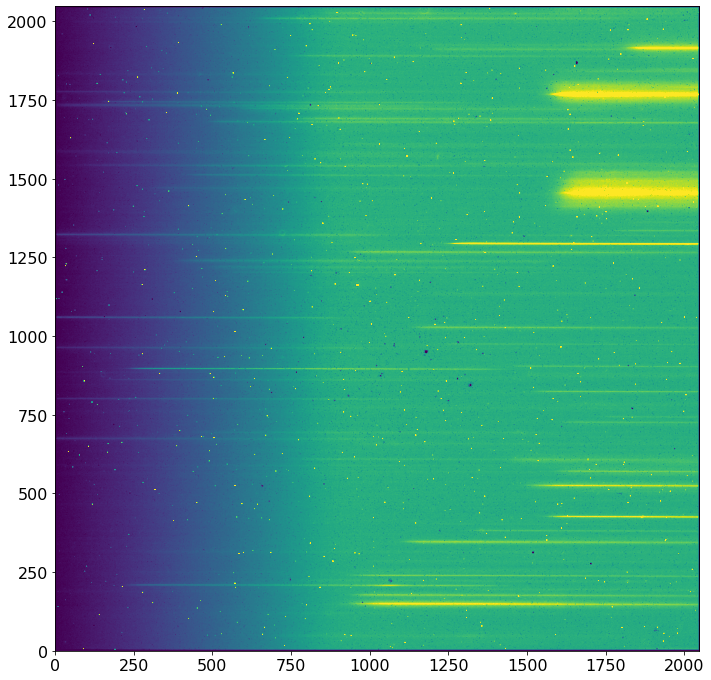

In [44]:
'''Check image of flat-fielded grism exposure'''

a_r_sci = fits.getdata(all_rate_list[0])

plt.close()
plt.figure(figsize = (10, 10))
plt.imshow(np.nan_to_num(a_r_sci), 
           vmin = np.nanpercentile(a_c_sci, 0.5), vmax = np.nanpercentile(a_c_sci, 99.5), origin = 'lower')
plt.tight_layout()

In [ ]:
'''
## Stage 2.2.b Generate Super Sky Background
'''
print("- Background + Hot pixel construction for %s - " % tmp_filter)
count_ac, count_bc, count_ar, count_br = 0, 0, 0, 0

for i, tmp_path_rate in enumerate(all_rate_list):
    tmp_grism_hd = fits.getheader(tmp_path_rate)
    tmp_filter, tmp_module, tmp_pupil = tmp_grism_hd['filter'], tmp_grism_hd['module'], tmp_grism_hd['pupil']
    print('>>> [%3d] ' % i, 'read %s' % tmp_path_rate, 
          '(%s %s %s)' % (tmp_filter, tmp_module, tmp_pupil))
    tmp_grism_rate = fits.getdata(tmp_path_rate, 'sci')
    if (tmp_module == 'A') & (tmp_pupil == 'GRISMC'): 
        if count_ac == 0:  arr_grism_rate_ac = tmp_grism_rate
        else: arr_grism_rate_ac = np.dstack((arr_grism_rate_ac, tmp_grism_rate))
        count_ac += 1
    if (tmp_module == 'B') & (tmp_pupil == 'GRISMC'): 
        if count_bc == 0:  arr_grism_rate_bc = tmp_grism_rate
        else: arr_grism_rate_bc = np.dstack((arr_grism_rate_bc, tmp_grism_rate))
        count_bc += 1
    if (tmp_module == 'A') & (tmp_pupil == 'GRISMR'): 
        if count_ar == 0:  arr_grism_rate_ar = tmp_grism_rate
        else: arr_grism_rate_ar = np.dstack((arr_grism_rate_ar, tmp_grism_rate))
        count_ar += 1
    if (tmp_module == 'B') & (tmp_pupil == 'GRISMR'): 
        if count_br == 0:  arr_grism_rate_br = tmp_grism_rate
        else: arr_grism_rate_br = np.dstack((arr_grism_rate_br, tmp_grism_rate))
        count_br += 1
print(count_ar, count_ac, count_br, count_bc)

'''
## generating background by module and pupil: 
'''
### if you only have C grism data, use below:
# list_arr_grism_rate = [arr_grism_rate_ac, arr_grism_rate_bc]
# list_arr_grism_module = ['A', 'B']
# list_arr_grism_pupil = ['GRISMC', 'GRISMC']
# list_arr_grism_filter = [tmp_filter] * 2

### if you only have R grism data, use below:
list_arr_grism_rate = [arr_grism_rate_ar, arr_grism_rate_br]
list_arr_grism_module = ['A', 'B']
list_arr_grism_pupil = ['GRISMR', 'GRISMR']
list_arr_grism_filter = [tmp_filter] * 2

### if you have both R and C grism data, use below:
# list_arr_grism_rate = [arr_grism_rate_ar, arr_grism_rate_ac, arr_grism_rate_br, arr_grism_rate_bc]
# list_arr_grism_module = ['A', 'A', 'B', 'B']
# list_arr_grism_pupil = ['GRISMR', 'GRISMC', 'GRISMR', 'GRISMC']
# list_arr_grism_filter = [tmp_filter] * 4

n_procs = 8
### Uncomment the following lines to do this step in parallel
# with Pool(np.min([n_procs, len(all_rate_list)])) as pool:
#     pool.starmap(background_grism_stage2, zip(list_arr_grism_rate, list_arr_grism_module, 
#                                               list_arr_grism_pupil, list_arr_grism_filter))


52 /xdisk/egami/fengwusun/grism_demo/grism_cal/jw01895001004_02101_00003_nrcalong_rate_lv1.5.fits


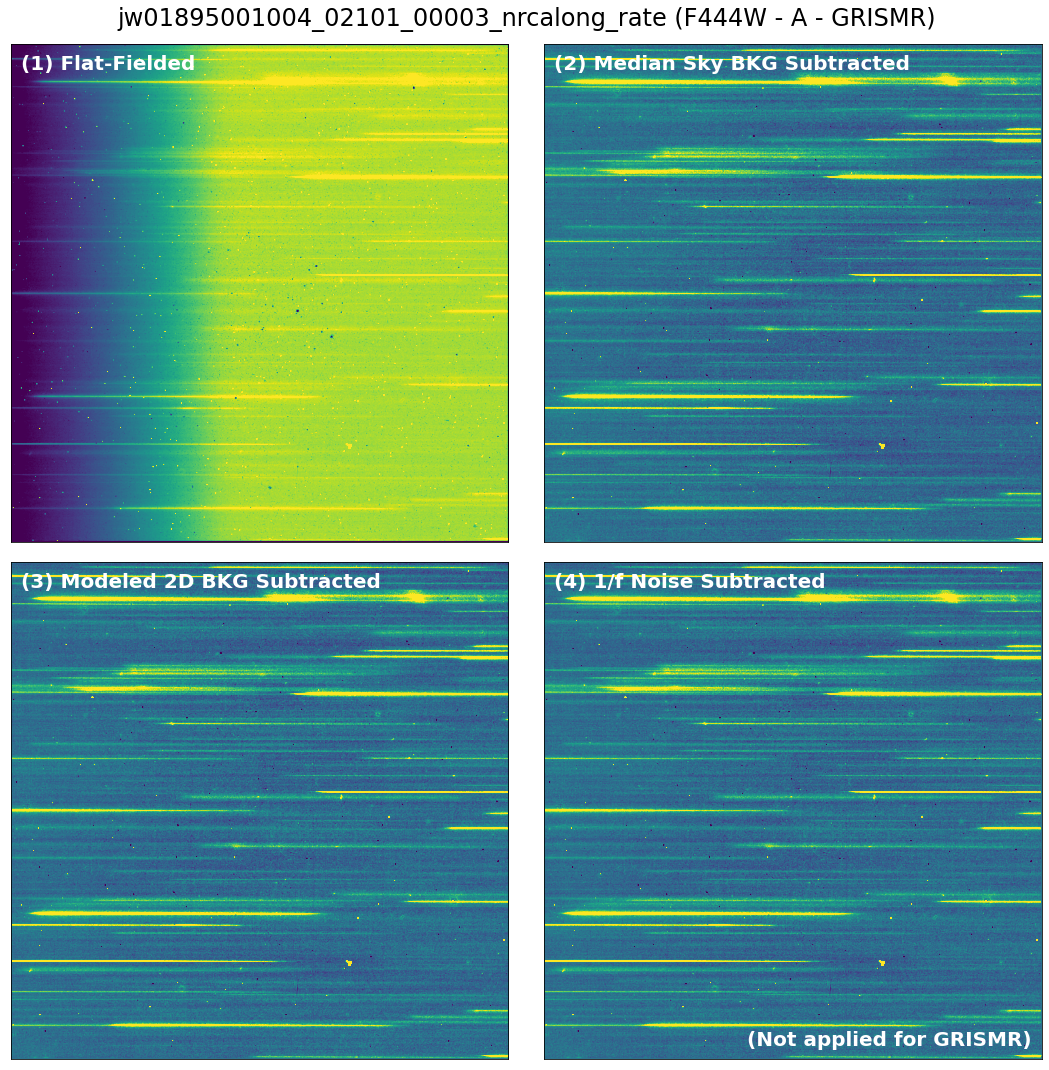

In [47]:
'''Check the grism image:'''
tmp_i = np.random.randint(len(all_rate_list))  ## select a random frame
# tmp_i = 0
print(tmp_i, all_rate_list[tmp_i])
tmp_grism_img = fits.getdata(all_rate_list[tmp_i])
tmp_grism_hd = fits.getheader(all_rate_list[tmp_i])
tmp_grism_bkg = fits.getdata(calibrated_dir + 'median_bkg_%s_mod%s_%s.fits' % 
                             (tmp_grism_hd['filter'], tmp_grism_hd['module'], tmp_grism_hd['pupil']))


'''start plotting'''

fig, ax = plt.subplots(2, 2, figsize = (15, 15))
ax = ax.flatten()

'''ax-0: flat-fielded grism image'''
ax[0].imshow(np.nan_to_num(tmp_grism_img),  origin = 'lower', 
             vmin = np.nanpercentile(tmp_grism_img, 2.5), vmax = np.nanpercentile(tmp_grism_img, 97.5))
corner_text(ax[0], s = '(1) Flat-Fielded', color = 'w', loc = 2, weight = 'bold', fontsize = 20)

'''ax-1: try to subtract sigma-clipped median sky background'''
tmp_grism_img = tmp_grism_img - tmp_grism_bkg
ax[1].imshow(np.nan_to_num(tmp_grism_img),  origin = 'lower', 
             vmin = np.nanpercentile(tmp_grism_img, 2.5), vmax = np.nanpercentile(tmp_grism_img, 97.5))
corner_text(ax[1], s = '(2) Median Sky BKG Subtracted', color = 'w', loc = 2, weight = 'bold', fontsize = 20)

if (tmp_grism_hd['filter'], tmp_grism_hd['module'], tmp_grism_hd['pupil'][-1]) == ('F322W2', 'B', 'R'):
    corner_text(ax[1], s = '(Not applied for modB - GRISMR)', color = 'w', loc = 4, weight = 'bold', fontsize = 20)
    
# mask-1 for background / 1-over-f noise subtraction: from segment map
_, tmp_med, tmp_rms = sigma_clipped_stats(tmp_grism_img[100:700,100:700])
segment_map = detect_sources(tmp_grism_img - tmp_med, tmp_rms * 2.0, npixels = 100)

### further background subtraction?
sigma_clip = SigmaClip(sigma = 2.5)
bkg_estimator = SExtractorBackground()
tmp_mask = np.zeros_like(segment_map.data)
bkg = Background2D(tmp_grism_img, (64, 64), filter_size = (9, 9), mask = tmp_mask,
                   sigma_clip = sigma_clip, bkg_estimator = bkg_estimator)
tmp_grism_img = tmp_grism_img - bkg.background

'''ax-2: try to subtract modeled 2D sky background'''
ax[2].imshow(np.nan_to_num(tmp_grism_img),  origin = 'lower', 
             vmin = np.nanpercentile(tmp_grism_img, 2.5), vmax = np.nanpercentile(tmp_grism_img, 97.5))
corner_text(ax[2], s = '(3) Modeled 2D BKG Subtracted', color = 'w', loc = 2, weight = 'bold', fontsize = 20)

### for grism C: subtract 1/f noise
if tmp_grism_hd['pupil'][-1] == 'C':
    _, tmp_med, tmp_rms = sigma_clipped_stats(tmp_grism_img[100:1700,100:1700].flatten()[::10])
    segment_map = detect_sources(tmp_grism_img, tmp_rms * 5.0, npixels = 20)
    rowSub, modelImg = rowamp_sub.do_backsub(tmp_grism_img, 
                                             amplifiers = 4, backgMask = segment_map.data == 0)
    tmp_grism_img = rowSub

'''ax-3: try to subtract 1/f noise'''
ax[3].imshow(np.nan_to_num(tmp_grism_img),  origin = 'lower', 
             vmin = np.nanpercentile(tmp_grism_img, 2.5), vmax = np.nanpercentile(tmp_grism_img, 97.5))
corner_text(ax[3], s = '(4) 1/f Noise Subtracted', color = 'w', loc = 2, weight = 'bold', fontsize = 20)
if tmp_grism_hd['pupil'][-1] == 'R':
    corner_text(ax[3], s = '(Not applied for GRISMR)', color = 'w', loc = 4, weight = 'bold', fontsize = 20)

tmp_title = '%s (%s - %s - %s)' % (os.path.basename(all_rate_list[tmp_i]).replace('_lv1.5.fits', ''),
                                   tmp_grism_hd['filter'], tmp_grism_hd['module'], tmp_grism_hd['pupil'])
fig.text(0.5, 0.985, s = tmp_title, ha = 'center', va = 'top', fontsize = 24,)
plt.subplots_adjust(left = 0.02, right = 0.98, top = 0.95, bottom = 0.01, wspace = 0.06, hspace = 0.04)

for tmp_ax in ax: 
    tmp_ax.set_xticks([]); tmp_ax.set_yticks([])
# plt.savefig(calibrated_dir + 'plots/%s_mod%s_%s_%2d_%s.pdf' % (tmp_grism_hd['filter'], tmp_grism_hd['module'], 
#                                                                tmp_grism_hd['pupil'], tmp_i, 
#                                                                tmp_title.split(' ')[0]),  dpi = 100)

plt.show()

In [50]:
'''If necessary, check background / segmentation / 1-over-f noise model'''
# plt.figure(figsize = (8, 8))
# plt.imshow(bkg.background, origin = 'lower', vmax = np.nanpercentile(bkg.background, 99.5))
# print(np.nanpercentile(bkg.background, [0, 100]))
# plt.imshow(tmp_mask, origin = 'lower')
# plt.imshow(modelImg)

'If necessary, check background / segmentation / 1-over-f noise model'

In [ ]:
'''
## Stage 2.2.c Background Ground (1/f noise subtraction) - For loop or pool multi-processing
'''

def my_grism_bkg_subtraction(rate_grism_file):
    print('>>> subtract background for %s ' % rate_grism_file)
    tmp_grism_fits = fits.open(rate_grism_file)
    tmp_grism_img = tmp_grism_fits[1].data
    tmp_grism_hd = tmp_grism_fits[0].header
    tmp_grism_bkg = fits.getdata(calibrated_dir + 'median_bkg_%s_mod%s_%s.fits' % 
                                 (tmp_grism_hd['filter'], tmp_grism_hd['module'], tmp_grism_hd['pupil']))
    plt.close()
    fig, ax = plt.subplots(2, 2, figsize = (15, 15))
    ax = ax.flatten()
    '''ax-0: flat-fielded grism image'''
    ax[0].imshow(np.nan_to_num(tmp_grism_img),  origin = 'lower', 
                 vmin = np.nanpercentile(tmp_grism_img, 2.5), vmax = np.nanpercentile(tmp_grism_img, 97.5))
    corner_text(ax[0], s = '(1) Flat-Fielded', color = 'w', loc = 2, weight = 'bold', fontsize = 20)

    '''ax-1: subtract sigma-clipped median sky background'''

    tmp_grism_img = tmp_grism_img - tmp_grism_bkg
    tmp_grism_fits[0].header['HISTORY'] = 'sigma-clipped median sky background subtracted by F. Sun on %s' % time.strftime("%Y/%m/%d",  time.localtime())
    ax[1].imshow(np.nan_to_num(tmp_grism_img),  origin = 'lower', 
                 vmin = np.nanpercentile(tmp_grism_img, 2.5), vmax = np.nanpercentile(tmp_grism_img, 97.5))
    corner_text(ax[1], s = '(2) Median Sky BKG Subtracted', color = 'w', loc = 2, weight = 'bold', fontsize = 20)
    if (tmp_grism_hd['filter'], tmp_grism_hd['module'], tmp_grism_hd['pupil'][-1]) == ('F322W2', 'B', 'R'):
        corner_text(ax[1], s = '(Not applied for modB - GRISMR)', color = 'w', loc = 4, weight = 'bold', fontsize = 20)

    # mask-1: from segment map
    _, tmp_med, tmp_rms = sigma_clipped_stats(tmp_grism_img[100:700,100:700])
    segment_map = detect_sources(tmp_grism_img - tmp_med, tmp_rms * 1.0, npixels = 100)

    ### further background subtraction?
    sigma_clip = SigmaClip(sigma = 2.5)
    bkg_estimator = SExtractorBackground()
    if (tmp_grism_hd['filter'], tmp_grism_hd['module'], tmp_grism_hd['pupil'][-1]) == ('F322W2', 'B', 'R'):
        tmp_mask = segment_map.data!=0
        bkg = Background2D(tmp_grism_img, (24, 24), filter_size = (5, 5), mask = tmp_mask,
                           sigma_clip = sigma_clip, bkg_estimator = bkg_estimator, exclude_percentile=50.)
        tmp_grism_img = tmp_grism_img - bkg.background
        tmp_grism_fits[0].header['HISTORY'] = 'SExtractor-modeled 2D background subtracted by F. Sun on %s' % time.strftime("%Y/%m/%d",  time.localtime())
#         bkg = Background2D(tmp_grism_img, (36, 36), filter_size = (5, 5), mask = tmp_mask,
#                            sigma_clip = sigma_clip, bkg_estimator = bkg_estimator, exclude_percentile=50.)
    else: 
        tmp_grism_img = tmp_grism_img
        tmp_grism_fits[0].header['HISTORY'] = 'No other 2D background subtracted'
        tmp_mask = np.zeros_like(segment_map.data)

    '''ax-2: subtract modeled 2D sky background'''
    ax[2].imshow(np.nan_to_num(tmp_grism_img),  origin = 'lower', 
                 vmin = np.nanpercentile(tmp_grism_img, 2.5), vmax = np.nanpercentile(tmp_grism_img, 97.5))
    corner_text(ax[2], s = '(3) Modeled 2D BKG Subtracted (Not applied)', color = 'w', loc = 2, weight = 'bold', fontsize = 20)

    ### for grism C: subtract 1/f noise
    if tmp_grism_hd['pupil'][-1] == 'C':
        _, tmp_med, tmp_rms = sigma_clipped_stats(tmp_grism_img[100:1700,100:1700].flatten()[::10])
        segment_map = detect_sources(tmp_grism_img, tmp_rms * 5.0, npixels = 20)
        rowSub, modelImg = rowamp_sub.do_backsub(tmp_grism_img, 
                                                 amplifiers = 4, backgMask = segment_map.data == 0)
        tmp_grism_img = rowSub
        tmp_grism_fits[0].header['HISTORY'] = '1/f noise subtracted by F. Sun on %s' % time.strftime("%Y/%m/%d",  time.localtime())

    '''ax-3: subtract 1/f noise'''
    ax[3].imshow(np.nan_to_num(tmp_grism_img),  origin = 'lower', 
                 vmin = np.nanpercentile(tmp_grism_img, 2.5), vmax = np.nanpercentile(tmp_grism_img, 97.5))
    corner_text(ax[3], s = '(4) 1/f Noise Subtracted', color = 'w', loc = 2, weight = 'bold', fontsize = 20)
    if tmp_grism_hd['pupil'][-1] == 'R':
        corner_text(ax[3], s = '(Not applied for GRISMR)', color = 'w', loc = 4, weight = 'bold', fontsize = 20)

    tmp_title = '%s (%s - %s - %s)' % (os.path.basename(rate_grism_file).replace('_lv1.5.fits', ''),
                                       tmp_grism_hd['filter'], tmp_grism_hd['module'], tmp_grism_hd['pupil'])
    fig.text(0.5, 0.985, s = tmp_title, ha = 'center', va = 'top', fontsize = 24,)
    plt.subplots_adjust(left = 0.02, right = 0.98, top = 0.95, bottom = 0.01, wspace = 0.06, hspace = 0.04)

    for tmp_ax in ax: 
        tmp_ax.set_xticks([]); tmp_ax.set_yticks([])
    plt.savefig(calibrated_dir + 'plots/%s_mod%s_%s_%s.pdf' % (tmp_grism_hd['filter'], tmp_grism_hd['module'], 
                                                               tmp_grism_hd['pupil'], tmp_title.split(' ')[0]),  dpi = 100)
    plt.close()
    
    '''Write Fits File'''
    tmp_grism_fits[1].data = tmp_grism_img
    tmp_grism_fits.writeto(rate_grism_file, overwrite = True)
    tmp_grism_fits.close()

n_procs = 8

### Uncomment the following lines to do this step in parallel:
# with Pool(np.min([n_procs, len(all_rate_list)])) as pool:
#     pool.map(my_grism_bkg_subtraction, all_rate_list)

### Or, uncomment the following lines to do this step in loop:
# for i, x in enumerate(all_rate_list):
#     print(i); my_grism_bkg_subtraction(x)
    

### Produce EMLINE maps for GRISM data

See [Kashino et al. (2023)](https://ui.adsabs.harvard.edu/abs/2023ApJ...950...66K/abstract) for methodology. With median filter in the dispersion direction, one can produce (fairly) continuum-subtracted and thus emission-line-only grism images. Run the following code block for an example:


4 /xdisk/egami/fengwusun/grism_demo/grism_cal/jw01895001001_02101_00003_nrcalong_rate_lv1.5.fits
EMLINE map produced in 4.405 seconds


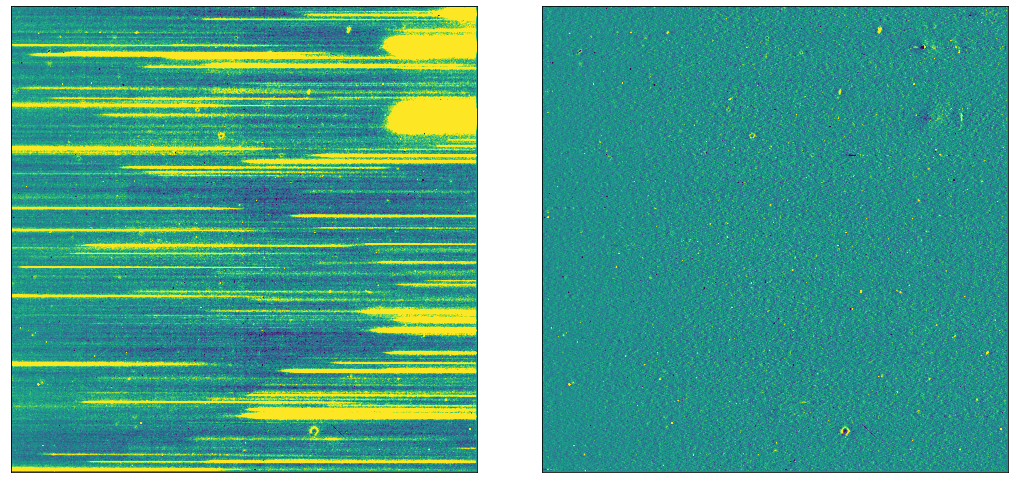

In [58]:
tmp_i = np.random.randint(len(all_rate_list))  ## select a random frame
# tmp_i = 0
print(tmp_i, all_rate_list[tmp_i])
tmp_grism_fits = fits.open(all_rate_list[tmp_i])
tmp_grism_sci = tmp_grism_fits['sci'].copy()
tmp_grism_img = tmp_grism_sci.data

time_a = time.time()
### median filter the data using a box with a hole:
L_box, L_mask = 25, 4
mf_footprint = np.ones((1, L_box * 2 + 1))
mf_footprint[:, L_box-L_mask:L_box+L_mask+1] = 0
tmp_grism_img_median = ndimage.median_filter(tmp_grism_img, footprint = mf_footprint, mode = 'reflect')
tmp_grism_img_emline = tmp_grism_img - tmp_grism_img_median   ## emission line map
rowSub, modelImg_horizontal = rowamp_sub.do_backsub(tmp_grism_img_emline, amplifiers = 1)
rowSub, modelImg_vertical   = rowamp_sub.do_backsub(rowSub.T, amplifiers = 1)
rowSub = rowSub.T

print('EMLINE map produced in %.3f seconds' % (time.time() - time_a))
fig, ax = plt.subplots(1, 2, figsize = (15, 7))
ax[0].imshow(np.nan_to_num(tmp_grism_img), vmin = -0.02, vmax = 0.02, origin = 'lower')
ax[1].imshow(np.nan_to_num(rowSub), vmin = -0.02, vmax = 0.02, origin = 'lower')

for tmp_ax in ax: tmp_ax.set_xticks([], []); tmp_ax.set_yticks([], [])
plt.tight_layout()

The left panel shows the 2D grism image before median-filtering (continuum subtraction), and the right panel shows the 2D grism image after the continuum subtraction. The residuals on the right panel are mainly (1) emission / absorption lines from galaxies and (2) cosmic rays (including snowballs) / hot pixels.

In [ ]:
'''
## Stage 2.2.d Continuum subraction & EMLINE image: - For loop or pool multi-processing
'''

def my_grism_cont_subtraction(rate_grism_file):
    tmp_grism_fits = fits.open(rate_grism_file)
    tmp_grism_sci = tmp_grism_fits['sci'].copy()
    tmp_grism_img = tmp_grism_sci.data
    tmp_grism_hd = tmp_grism_fits[0].header

    ### median filter the data using a box with a hole:
    L_box, L_mask = 25, 4
    if tmp_grism_hd['pupil'][-1] == 'R':
        mf_footprint = np.ones((1, L_box * 2 + 1))
        mf_footprint[:, L_box-L_mask:L_box+L_mask+1] = 0
    elif tmp_grism_hd['pupil'][-1] == 'C':
        mf_footprint = np.ones((L_box * 2 + 1, 1))
        mf_footprint[L_box-L_mask:L_box+L_mask+1,:] = 0
    else: raise KeyError('pupil should be in GRISMR or GRISMC!')
    tmp_grism_img_median = ndimage.median_filter(tmp_grism_img, footprint = mf_footprint, mode = 'reflect')
    tmp_grism_img_emline = tmp_grism_img - tmp_grism_img_median   ## emission line map
    ### horizontal stripe (1/f) removal
    rowSub, modelImg_horizontal = rowamp_sub.do_backsub(tmp_grism_img_emline, amplifiers = 1)
    ### vertical stripe (1/f) removal
    rowSub, modelImg_vertical   = rowamp_sub.do_backsub(rowSub.T, amplifiers = 1)
    rowSub = rowSub.T
    print('EMLINE map produced for %s' % rate_grism_file)
    
    ### save as an extension in the same files
    tmp_grism_sci.header['EXTNAME'] = 'EMLINE'
    tmp_grism_sci.header['HISTORY'] = 'Continuum Subtracted by Median Filter, Line-Only Map'
    tmp_grism_sci.data = rowSub
    if len(tmp_grism_fits) == 8: tmp_grism_fits.append(tmp_grism_sci)
    else: tmp_grism_fits['EMLINE'] = tmp_grism_sci
        
    fig, ax = plt.subplots(1, 2, figsize = (14.5, 7))
    ax[0].imshow(np.nan_to_num(tmp_grism_img), vmin = -0.02, vmax = 0.02, origin = 'lower')
    ax[1].imshow(np.nan_to_num(rowSub), vmin = -0.02, vmax = 0.02, origin = 'lower')
    for tmp_ax in ax: tmp_ax.set_xticks([], []); tmp_ax.set_yticks([], [])
    plt.tight_layout()
    for tmp_ax in ax: 
        tmp_ax.set_xticks([]); tmp_ax.set_yticks([])
    plt.subplots_adjust(left = 0.02, right = 0.98, top = 0.95, bottom = 0.01, wspace = 0.06, hspace = 0.04)
    plt.savefig(calibrated_dir + 'plots/%s_mod%s_%s_%s_EMLINE.pdf' % (tmp_grism_hd['filter'], tmp_grism_hd['module'], 
                                                                      tmp_grism_hd['pupil'], os.path.basename(rate_grism_file).replace('_lv1.5.fits', '')),  dpi = 100)
    plt.close()
    
    '''Write Fits File'''
    tmp_grism_fits.writeto(rate_grism_file, overwrite = True)
    tmp_grism_fits.close()

n_procs = 8

### Uncomment the following lines to do this step in parallel:
# with Pool(np.min([n_procs, len(all_rate_list)])) as pool:
#     pool.map(my_grism_cont_subtraction, all_rate_list)

At this step, you should have completed the `stage-2a` reduction for the LW grism images. The files (`jw*nrc[a-b]long_rate_lv1.5.fits`) you get are flat-fielded, wcs-assigned and background subtracted LW grism images. They also have an additional extenision named `EMLINE` compared with jwst pipeline products. Indeed, they are almost ready for spectral extraction. However, there is one more thing that you will need to pay attention, which is **astrometry**.

The spectral and spatial resolution of NIRCam (grism) is so high that a small astrometric offset (0.3" -> 5 LW pix) can give you a completely trash 2D or 1D spectra. The quality of astrometric correction usually limits the quality of spectral extraction and flux/wavelength calibration. One good news is that we have SW simultaneous direct imaging data which can be used to empirically calibrate the LW grism astrometry. This is, assuming that when SW direct imaging data is registered to certain astrometric catalog by applying `dRA`, `dDEc` and `theta` (i.e., x/y offset and rotation), the same offset will be applied to the LW grism fits header and the LW grism astrometry should be good. Such a registration relies on the internal alignment between NIRCam SW and LW instrument aperture and it may introduce astrometric residuals. However, these residuals should be stable and have been included in the grism spectral tracing models.

When using the different SW/LW filter combinations, different filters will also introduce astrometric offset called **"filter offset"**. In my personal opinion, this has not been well understood and calibrated throughout commissioning and it can cause most of the tracing and wavelength error (a few pixels). We will get to this point later.

## 4. Astrometry Characterization using SW Direct imaging


In [98]:
# list_sw_rate = np.concatenate([glob.glob('/xdisk/egami/fengwusun/GO/FRESCO/SW_direct/' + os.path.basename(x).replace('long', '*').replace('_rate', '_cal')) for x in list_rate])

# output_dir = '/xdisk/egami/fengwusun/grism_demo/direct_imaging/'
# for i, tmp_rate in enumerate(list_sw_rate[:]):
#     if os.path.isfile(output_dir + os.path.basename(tmp_rate)) : continue
#     os.system('cp %s %s%s' % (tmp_rate, output_dir, os.path.basename(tmp_rate)))
#     print('%3d > ' % i, end = "  ")

In [99]:
'''Getting all SW rate fits files by wildcards'''
#### This the path of the files that I downloaded, change your path!
list_rate_sw = np.array(glob.glob('/xdisk/egami/fengwusun/grism_demo/direct_imaging/jw*_nrc[a-b][1-4]_rate.fits'))

list_rate_sw.sort()
print(len(list_rate_sw))

'''List of filter, pupil, module, target, exposure time, etc.'''

list_sw_filter = []
list_sw_pupil = []
list_sw_module = []
list_sw_target = []
list_sw_exp = []
for x in list_rate_sw:
    tmp_hd = fits.getheader(x)
    list_sw_filter.append(tmp_hd['FILTER'])
    list_sw_pupil.append(tmp_hd['PUPIL'])
    list_sw_module.append(tmp_hd['MODULE'])
    list_sw_target.append(tmp_hd['TARGPROP'])
    list_sw_exp.append(tmp_hd['EFFEXPTM'])
list_sw_filter = np.array(list_sw_filter)
list_sw_pupil = np.array(list_sw_pupil)
list_sw_module = np.array(list_sw_module)
list_sw_target = np.array(list_sw_target)

### print SW filters and modules
print(np.unique(list_sw_filter), np.unique(list_sw_module), np.unique(list_sw_target))


512
['F182M' 'F210M'] ['A' 'B'] ['GOODS-S-CENTER']


For FRESCO data in our example, if I'm looking at the F444W grism data, the SW simultaneous exposures are taken in either F182M or F210M filter, so I have to select all SW imaging files listed above. Before you can run astrometric correction for these files, you will need to **reduce it through the [JWST stage-2 pipeline](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image2.html#calwebb-image2) (i.e., `rate.fits` to `cal.fits`)** to make sure that the images are fully calibrated. You are also welcome to directly download the `cal.fits` files from the MAST archive, although I prefer not because the `cal.fits` is subject to a lot of calibration references and the one used in archive might be not optimal (e.g., outdated).


In [100]:
'''Run stage 2 in parallel'''

pid = '1895'
#### This the path of the files that I downloaded, change your path!
output_dir = '/xdisk/egami/fengwusun/grism_demo/direct_imaging/'
wing = 'sw'

def reduce_img_stage2(rate_image_file):
    '''Function to reduce jwst/nircam image at stage-2 
    '''
    
    ##### 2-1 generate json file:
    dict_lev2 = {"asn_type" : "image2", 
                 "asn_rule": "DMSLevel2bBase",
                 "version_id": None, "code_version": jwst.__version__,
                 "degraded_status": "No known degraded exposures in association.",
                 # "program": pid,
                 "constraints": "No constraints",  "asn_id": "a3001", "asn_pool": "none",
                 }
    dict_products = []
    
    if wing == 'lw': tmp_basename = os.path.basename(rate_image_file)[:34]
    elif wing == 'sw': tmp_basename = os.path.basename(rate_image_file)[:31]
    tmp_dict_members = {"expname": rate_image_file, "exptype": "science", }
    tmp_dict_product = {"name" :   os.path.basename(rate_image_file.replace('_rate_rowsub.fits', '').replace('_rate.fits', '')), 
                        "members" : [tmp_dict_members]}
    dict_products.append(tmp_dict_product)

    dict_lev2['products'] = dict_products
    #####  Serializing json 
    json_object = json.dumps(dict_lev2, indent = 4)
    #####  Writing to sample.json
    with open(output_dir + "nircam_stage2_dir_img_%s.json" % tmp_basename, "w") as outfile:
        outfile.write(json_object)
        
    os.chdir(output_dir) # + 'calibrated/')
    asn_file = "nircam_stage2_dir_img_%s.json" % tmp_basename
    image2 = calwebb_image2.Image2Pipeline()
    image2.output_dir = './'
    image2.save_results = True
    image2.resample.skip = True
    ##### Call the run() method
    image2.run(asn_file)
    return None

### Uncomment the following lines to do this step in parallel:
# n_procs = 8
# with Pool(n_procs) as pool:
#     pool.map(reduce_img_stage2, list_rate_sw)

### if you only have to run a subset
# list_cal_sw = np.array([output_dir + os.path.basename(x).replace('_rate.fits', '_cal.fits').replace('_rate_rowsub.fits', '_cal.fits')  
#                             for x in list_rate_sw])
# arg_cal = np.where([os.path.isfile(x)==False for x in list_cal_sw])[0]
# with Pool(n_procs) as pool:
#     pool.map(reduce_img_stage2, list_rate_sw[arg_cal])

### other examples:
# with Pool(n_procs) as pool:
#     pool.map(reduce_img_stage2, list_rate_sw[[os.path.isfile(x.replace('rate.fits', 'cal.fits')) == False for x in list_rate_sw]])


os.system('rm %snircam_stage2_dir_img_*.json'% output_dir)


rm: cannot remove '/xdisk/egami/fengwusun/grism_demo/direct_imaging/nircam_stage2_dir_img_*.json': No such file or directory


256

If you have run the following steps in another jupyter notebook (like me):

- reduced all `*_rate.fits` files to stage-2 as `*_cal_fits`, including flat-fielding, distortion correction, photometric zeropoint assignment and 1/f noise subtraction.

- register the WCS of all `*_cal_fits` to an astrometric catalog, constructed at LW.

It will then be good to detect stars in stage-2 products `*_cal_fits`, but the WCS information there has been corrected. What we will need is catalogs of stars in all SW images **without** any astrometric correction, so we can correct for x/y offset and rotration ourselves and pass that to LW. If you haven't corrected anything for `_rate.fits` and `_cal.fits` files, great, you can directly run `daofind()` on the `_cal.fits` files, get catalogs and compute the astrometric offsets. If you have corrected the astrometry (like me), we will restore the original astrometry to extract the catalog. Therefore, for the following code block, **please modify the scripts to let it suit your cases.**


In [106]:
all_rate_sw_list = list_rate_sw # [list_sw_filter == 'F210M']
print(len(all_rate_sw_list), 'SW rate files selected.')

'''Path to my direct imaging folder 
 which has rate files, wcs uncorrected (original),
        and cal files, wcs corrected   (modified).
'''
# direct_image_dir = '/xdisk/egami/fengwusun/grism_demo/direct_imaging/'
direct_image_dir = output_dir 

# i = 72
# tmp_rate_sw = all_rate_sw_list[i]

def my_daofind_sw_fits(tmp_rate_sw):
    '''
    If SW cal.fits images have been astrometrically corrected and passed through stage-2 pipelines,
    we then need to restore the original atrometry and use the images provided by stage-2 pipeline
    '''
    ## assign wcs 
    rate_sw_fits = fits.open(tmp_rate_sw)
    rate_sw_hd = rate_sw_fits[0].header
    ### read distortion assignment
    siaf_file = crds.getreferences(rate_sw_hd, reftypes = ['distortion'], ignore_cache = False)['distortion']
    ### assign default WCS
    rate_sw_wcs_step = assign_wcs.assign_wcs_step.AssignWcsStep(override_distortion = siaf_file)
    rate_sw_IM = datamodels.image.ImageModel(rate_sw_fits)
    rate_sw_IM_wcs = rate_sw_wcs_step(rate_sw_IM)
    tmp_wcs = rate_sw_IM_wcs.get_fits_wcs()       ## this is the default wcs from observational parameters
    rate_sw_IM_wcs.close()
    rate_sw_fits.close()

    ### well-processed SW cal.fits files 
    direct_sw_fits = fits.open(direct_image_dir + os.path.basename(tmp_rate_sw).replace('_rate.fits', '_cal.fits'))
    # tmp_wcs = wcs.WCS(direct_sw_fits[1].header)
    tmp_coord_center = wcs.utils.pixel_to_skycoord(1024.5, 1024.5, tmp_wcs)
    ### construct detection image
    tmp_detect_img = np.nan_to_num(direct_sw_fits['sci'].data)
    bkg_estimator = MedianBackground()
    bkg = Background2D(tmp_detect_img, (64, 64), filter_size = (5, 5),
                       sigma_clip = SigmaClip(sigma = 3.), bkg_estimator = bkg_estimator)
    tmp_detect_std =  sigma_clipped_stats(tmp_detect_img[100:1500,100:1500].flatten()[::7], 
                                          sigma = 3, maxiters = 10)[-1]
    tmp_detect_img = (tmp_detect_img - bkg.background) / tmp_detect_std
    # tmp_detect_img[direct_sw_fits['dq'].data >= 1] = 0
    
    ### run DAOStarFinder - change parameters (FWHM or Threshold if needed)
    print('run daofind on %s' % os.path.basename(tmp_rate_sw).replace('_rate.fits', '_cal.fits'))
    daofind = DAOStarFinder(fwhm = 5.0, threshold = 7.) # DAOStarFinder(fwhm = 2.5, threshold = 8.)
    tmp_tb_daofind = daofind(tmp_detect_img)
    tmp_tb_daofind['detector'] = direct_sw_fits[0].header['detector'].lower()
    tmp_tb_daofind['skycoord'] = wcs.utils.pixel_to_skycoord(tmp_tb_daofind['xcentroid'], tmp_tb_daofind['ycentroid'], tmp_wcs)
    ### Save SW catalogs 
    ascii.write(tmp_tb_daofind, calibrated_dir + 'astrom/%s' % os.path.basename(tmp_rate_sw).replace('_rate.fits', '_daofind.cat'),
                format = 'ecsv', overwrite = True)
    direct_sw_fits.close()

if os.path.isdir(calibrated_dir + 'astrom/') == False: 
    os.mkdir(calibrated_dir + 'astrom/') # used to save astrometry-related files
    
n_procs = 8
### Uncomment the following lines to generate source catalogs in parallel:
# with Pool(np.min([n_procs, len(all_rate_sw_list)])) as pool:
#     pool.map(my_daofind_sw_fits, all_rate_sw_list)

'''If some cores are corrupted, run the following for unfinished fits'''
idx_unfinished = np.array([os.path.isfile(calibrated_dir + 'astrom/%s' % os.path.basename(x).replace('_rate.fits', '_daofind.cat')) == False
                           for x in all_rate_sw_list])
print(np.sum(idx_unfinished), 'unfinished.')
# with Pool(np.min([n_procs, len(all_rate_sw_list[idx_unfinished])])) as pool:
#     pool.map(my_daofind_sw_fits, all_rate_sw_list[idx_unfinished])

512 SW rate files selected.
0 unfinished.


With the SW catalogs produced above, you can then use an astrometric catalog to calibrate the astrometry of each SW exposures. This information will be recorded in a table called `tb_sw_astrometry` and will be passed to the next step for LW grism astrometry correction.

#### Read LW direct imaging catalog, compare with SW extracted catalog for grism WCS correction

In this example, the astrometric catalog for FRESCO data is the GOODS-S CHArGE imaging catalog in HST F160W band (based on G. Brammer's CHArGE F160W imaging data, which have been registered to GAIA DR2 frame). You can get access to it at [http://gxn.as.arizona.edu/~sunfengwu/grism_demo/goods_s_charge_F160W_daofind.cat](http://gxn.as.arizona.edu/~sunfengwu/grism_demo/goods_s_charge_F160W_daofind.cat). 

In [138]:
'''Read astrometric catalog'''
tb_LW = ascii.read('/xdisk/egami/fengwusun/grism_demo/goods_s_charge_F160W_daofind.cat')
tmp_RA, tmp_DEC = tb_LW['skycoord'].ra.value, tb_LW['skycoord'].dec.value
tb_LW[:5]


<Table length=5>
  id      xcentroid      ...                skycoord               
                         ...                deg,deg                
int64      float64       ...                SkyCoord               
----- ------------------ ... --------------------------------------
 7392  6566.832908390254 ...  53.03614064637727,-27.792959325180345
12421  4386.791126730554 ...  53.10459699062078,-27.734300413681286
 4828 3382.5791216968414 ... 53.136135467404735,-27.829107041178208
 6855 2513.0215644157392 ...  53.16343417759751,-27.799616886443026
 7514 2766.5877782150637 ...   53.15546828106797,-27.79156745333827

In [139]:
'''*_cal.fits files in this band (F182M & F210M)'''
list_img_cal_this_band = list_rate_sw 
list_img_cal_this_band = np.array([direct_image_dir + os.path.basename(x).replace('_rate.fits', '_cal.fits') 
                                   for x in list_img_cal_this_band])

In the following code block, you will run a loop to compute the x/y offset and rotation of four SW exposures associated with the LW grism exposure (e.g., A1-4 for module A) and save the astrometric shift information in the `tb_sw_astrometry` table. Note that module A/B might have different offsets so you have to group them separately.

>>>  Astrometry (RA/DEC) offsets calculation for 512 SW Frames
  0 >> jw01895001001_02101_00001_nrca 
           N_mathch = 44
 RA_image -  RA_ref = 0.038"±0.002"
DEC_image - DEC_ref = -0.065"±0.002"
     rotation theta = 0.005±0.001 deg
  1 >> jw01895001001_02101_00001_nrcb 
           N_mathch = 95
 RA_image -  RA_ref = 0.137"±0.002"
DEC_image - DEC_ref = 0.170"±0.002"
     rotation theta = 0.022±0.001 deg
  2 >> jw01895001001_02101_00002_nrca 
           N_mathch = 48
 RA_image -  RA_ref = 0.036"±0.002"
DEC_image - DEC_ref = -0.069"±0.002"
     rotation theta = 0.006±0.001 deg
  3 >> jw01895001001_02101_00002_nrcb 
           N_mathch = 95
 RA_image -  RA_ref = 0.136"±0.002"
DEC_image - DEC_ref = 0.164"±0.002"
     rotation theta = 0.020±0.001 deg
  4 >> jw01895001001_02101_00003_nrca 
           N_mathch = 52
 RA_image -  RA_ref = 0.036"±0.002"
DEC_image - DEC_ref = -0.074"±0.002"
     rotation theta = 0.009±0.001 deg
  5 >> jw01895001001_02101_00003_nrcb 
           N_mathch = 103

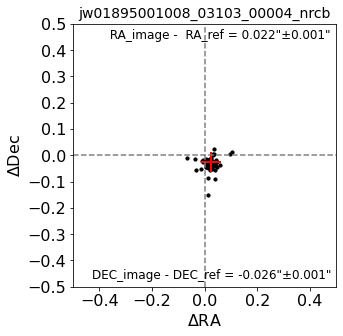

In [140]:
'''SW astrometry table'''
tb_sw_astrometry = Table(names = ['expName','N_match', 'dRA', 'dDEC', 'dRA_err', 'dDEC_err', 'theta', 'theta_err'], 
                         dtype = ['S40', 'i4', 'f4', 'f4' , 'f4', 'f4', 'f4', 'f4'])
tb_sw_astrometry.meta['comments'] = ['RA/Dec offsets are in arcsec and absolute', 
                                     'i.e., cos(Dec) projection has been considered.',
                                     '  >> dRA  =  RA_daofind -  RA_gaia',
                                     '  >> dDEC = DEC_daofind - DEC_gaia',
                                     'generated by F. Sun (steward) on %s' % time.strftime("%Y/%m/%d",  time.localtime())]
for colname in tb_sw_astrometry.colnames[2:]: tb_sw_astrometry[colname].info.format = '.4f'
sigma_clip = SigmaClip(sigma = 2.)

'''Run the following loop to compute astrometric offsets for each group of SW exposures.'''
print('>>>  Astrometry (RA/DEC) offsets calculation for %3d SW Frames' % len(list_img_cal_this_band))
for k in range(len(list_img_cal_this_band) // 4):
    ## For each cal.fits, get all the paths of csal.fits from all four detector.
    tmp_img_cal_path = list_img_cal_this_band[k * 4]
    tmp_img_cal_path_base = os.path.basename(tmp_img_cal_path)[:30]
    tmp_obsnum = int(tmp_img_cal_path_base[7:10])
    tmp_grism_LW_path = calibrated_dir + tmp_img_cal_path_base + 'long_rate_lv1.5.fits'
    if os.path.isfile(tmp_grism_LW_path) == False: continue
    tmp_grism_hd_sci = fits.getheader(tmp_grism_LW_path, 1)
    print('%3d >> %s ' % (k, tmp_img_cal_path_base))
    tmp_img_cal_hd = fits.getheader(tmp_img_cal_path, 0)
    tmp_detector = tmp_img_cal_hd['DETECTOR'].lower()
    tmp_img_cal_sci_hd = fits.getheader(tmp_img_cal_path, 'sci')
    tmp_time_obs = Time(tmp_img_cal_sci_hd['MJD-AVG'], format ='mjd')
    tmp_detectors = np.array(['%s%d' % (tmp_detector[:-1], tmp_det) for tmp_det in [1, 2, 3, 4]])
    tmp_img_cal_paths = np.array([tmp_img_cal_path.replace(tmp_detector, x) for x in tmp_detectors])
    
    
    ## Run DAOFIND to get a star catalog:
    daofind = DAOStarFinder(fwhm = 3.0, threshold = 8.)
    for j, tmp_img_cal_path in enumerate(tmp_img_cal_paths):
        if os.path.isfile(tmp_img_cal_path)==False: print('%s not found!' % tmp_img_cal_path); continue
        tmp_img_cal_sci_hd = fits.getheader(tmp_img_cal_path, 'sci')
        '''Directly use prepared SW DAOFIND catalog'''
        tmp_tb_daofind = ascii.read(calibrated_dir + 'astrom/%s' % os.path.basename(tmp_img_cal_path).replace('_cal.fits', '_daofind.cat').replace('_rate.fits', '_daofind.cat'),
                                    format = 'ecsv')
        '''no need to do daofind again'''
#         tmp_wcs = wcs.WCS(tmp_img_cal_sci_hd)
#         tmp_coord_center = SkyCoord(tmp_img_cal_sci_hd['crval1'], tmp_img_cal_sci_hd['crval2'], unit = (u.deg, u.deg))
#         tmp_detect_img = np.nan_to_num(fits.getdata(tmp_img_cal_path, 'sci'))
#         bkg_estimator = MedianBackground()
#         bkg = Background2D(tmp_detect_img, (64, 64), filter_size = (5, 5),
#                            sigma_clip = SigmaClip(sigma = 3.), bkg_estimator = bkg_estimator)
#         tmp_detect_std =  sigma_clipped_stats(tmp_detect_img[100:500,100:500], sigma = 3, maxiters = 10)[-1]
#         tmp_detect_img = (tmp_detect_img - bkg.background) / tmp_detect_std
#         # tmp_detect_img[fits.getdata(tmp_img_cal_path, 'dq') >= 1] = 0
#         # tmp_detect_img = np.nan_to_num(fits.getdata(tmp_img_cal_path, 'sci')/np.clip(fits.getdata(tmp_img_cal_path, 'err'), 1e-8, 1e8))
#         tmp_tb_daofind = daofind(tmp_detect_img)
#         tmp_tb_daofind['detector'] = tmp_detectors[j]
#         tmp_tb_daofind['skycoord'] = wcs.utils.pixel_to_skycoord(tmp_tb_daofind['xcentroid'], tmp_tb_daofind['ycentroid'], tmp_wcs)
        if j == 0 : tb_daofind = tmp_tb_daofind
        else: tb_daofind = vstack((tb_daofind, tmp_tb_daofind))
    tb_daofind = tb_daofind[np.argsort(tb_daofind['peak'])][-200:]
    tmp_coord_daofind = tb_daofind['skycoord'] 
    
    
    '''Astrometric Source RA & DECs'''
    # tmp_coord_gaia = SkyCoord(tmp_RA, tmp_DEC, unit = (u.deg, u.deg))
    # arg_LW_bright = np.where((tb_LW['MAG_AUTO'].data < 22.5) & (tb_LW['MAG_AUTO'].data > 16.5))[0]
    # tmp_coord_LW = SkyCoord(tb_LW['X_WORLD'][arg_LW_bright], tb_LW['Y_WORLD'][arg_LW_bright], 
    #                           unit = (u.deg, u.deg))
    tmp_coord_LW = SkyCoord(tmp_RA, tmp_DEC, unit = (u.deg, u.deg))
    ### rough center of the frame
    tmp_coord_center = SkyCoord(np.median(tmp_coord_daofind.ra), np.median(tmp_coord_daofind.dec))
    ### only select sources close to the center
    tmp_coord_LW = tmp_coord_LW[tmp_coord_center.separation(tmp_coord_LW) < 4 * u.arcmin]
    
    ## Cross match DAOFind Catalog with Gaia Catalog
    idx_daofind, d2d, _ = tmp_coord_LW.match_to_catalog_sky(tmp_coord_daofind)
    idx_LW = np.where(d2d < 0.50 * u.arcsec)[0]
    idx_daofind = idx_daofind[idx_LW]

    ## Compute RA/DEC offset
    tmp_ra_offset = ((tmp_coord_daofind[idx_daofind].ra - tmp_coord_LW[idx_LW].ra) 
                     * np.cos(tmp_coord_LW[idx_LW].dec)).to(u.arcsec).value
    tmp_dec_offset = (tmp_coord_daofind[idx_daofind].dec - tmp_coord_LW[idx_LW].dec).to(u.arcsec).value

    ## Find center of clustering, sigma-clipped RA/DEC offset
    dbin = 0.1
    tmp_ra_bins = np.arange(tmp_ra_offset.min()-0.01 - dbin/2, tmp_ra_offset.max() + dbin + 0.01, dbin)
    tmp_dec_bins = np.arange(tmp_dec_offset.min()-0.01- dbin/2, tmp_dec_offset.max() + dbin + 0.01, dbin)
    offset_hist2d = np.histogram2d(tmp_ra_offset, tmp_dec_offset, bins = (tmp_ra_bins, tmp_dec_bins))[0]
    idx_ra, idx_dec = np.where(offset_hist2d == np.nanmax(offset_hist2d))
    idx_ra, idx_dec = idx_ra[0], idx_dec[0]
    arg_clipped = np.where((tmp_ra_offset > tmp_ra_bins[idx_ra] - 1.5 * dbin) & 
                           (tmp_ra_offset < tmp_ra_bins[idx_ra] + 1.5 * dbin) &
                           (tmp_dec_offset > tmp_dec_bins[idx_dec] - 1.5 * dbin) & 
                           (tmp_dec_offset < tmp_dec_bins[idx_dec] + 1.5 * dbin))[0]
    tmp_ra_offset_clipped, tmp_dec_offset_clipped = tmp_ra_offset[arg_clipped], tmp_dec_offset[arg_clipped]
    idx_daofind = idx_daofind[arg_clipped]
    
    tmp_ra_offset_med, tmp_ra_offset_std = sigma_clipped_stats(tmp_ra_offset_clipped)[1:]
    tmp_dec_offset_med, tmp_dec_offset_std = sigma_clipped_stats(tmp_dec_offset_clipped)[1:]
    
    ## Compute rotation:
    poly_dec_dRA = optimize.curve_fit(f = linear, xdata = tmp_coord_daofind[idx_daofind].dec, ydata = tmp_ra_offset_clipped)[0]
    poly_ra_dDEC = optimize.curve_fit(f = linear, xdata = tmp_coord_daofind[idx_daofind].ra, ydata = tmp_dec_offset_clipped)[0]
    ## iter-1
    arg_dec_dRA = np.where(sigma_clip(np.polyval(poly_dec_dRA, tmp_coord_daofind[idx_daofind].dec.value) - tmp_ra_offset_clipped).mask == False)[0]
    poly_dec_dRA = optimize.curve_fit(f = linear, xdata = tmp_coord_daofind[idx_daofind].dec[arg_dec_dRA], ydata = tmp_ra_offset_clipped[arg_dec_dRA])[0]
    arg_ra_dDEC = np.where(sigma_clip(np.polyval(poly_ra_dDEC, tmp_coord_daofind[idx_daofind].ra.value) - tmp_dec_offset_clipped).mask == False)[0]
    poly_ra_dDEC = optimize.curve_fit(f = linear, xdata = tmp_coord_daofind[idx_daofind].ra[arg_ra_dDEC], ydata = tmp_dec_offset_clipped[arg_ra_dDEC])[0]
    ## iter-2
    arg_dec_dRA = np.where(sigma_clip(np.polyval(poly_dec_dRA, tmp_coord_daofind[idx_daofind].dec.value) - tmp_ra_offset_clipped).mask == False)[0]
    poly_dec_dRA, pcov_dec_dRA = optimize.curve_fit(f = linear, xdata = tmp_coord_daofind[idx_daofind].dec[arg_dec_dRA], ydata = tmp_ra_offset_clipped[arg_dec_dRA])
    arg_ra_dDEC = np.where(sigma_clip(np.polyval(poly_ra_dDEC, tmp_coord_daofind[idx_daofind].ra.value) - tmp_dec_offset_clipped).mask == False)[0]
    poly_ra_dDEC, pccov_ra_dDEC = optimize.curve_fit(f = linear, xdata = tmp_coord_daofind[idx_daofind].ra[arg_ra_dDEC], ydata = tmp_dec_offset_clipped[arg_ra_dDEC])
    perr_dec_dRA = np.sqrt(np.diag(pcov_dec_dRA))
    perr_ra_dDEC = np.sqrt(np.diag(pccov_ra_dDEC))
    ## combine two direction
    cos_factor = np.cos(np.deg2rad(np.median(tmp_coord_daofind[idx_daofind].dec.value)))
    theta_as_deg = (poly_dec_dRA[0] / perr_dec_dRA[0] - poly_ra_dDEC[0] / perr_ra_dDEC[0]) / (1/perr_dec_dRA[0] + cos_factor / perr_ra_dDEC[0]) / 3600.
    theta_as_deg_err = np.sum(perr_dec_dRA[0]**2 + (perr_ra_dDEC[0] / cos_factor)**2)**0.5 / 2. / 3600.
    theta_as_deg = np.rad2deg(theta_as_deg)
    theta_as_deg_err = np.rad2deg(theta_as_deg_err)
    
    tmp_ra_offset_med = tmp_grism_hd_sci['CRVAL2'] * poly_dec_dRA[0] + poly_dec_dRA[1]
    tmp_dec_offset_med = tmp_grism_hd_sci['CRVAL1'] * poly_ra_dDEC[0] + poly_ra_dDEC[1]

    tmp_ra_offset_std = sigma_clipped_stats(tmp_ra_offset_clipped)[2]
    tmp_dec_offset_std = sigma_clipped_stats(tmp_dec_offset_clipped)[2]
    print('           N_mathch = %d' % len(arg_clipped))
    print(' RA_image -  RA_ref = %.3f"±%.3f"' % (tmp_ra_offset_med,  tmp_ra_offset_std  / np.sqrt(len(arg_clipped)) ))
    print('DEC_image - DEC_ref = %.3f"±%.3f"' % (tmp_dec_offset_med, tmp_dec_offset_std / np.sqrt(len(arg_clipped)) ))
    print('     rotation theta = %.3f±%.3f deg' % (theta_as_deg, theta_as_deg_err))
    tb_sw_astrometry.add_row([tmp_img_cal_path_base, len(arg_clipped),
                              tmp_ra_offset_med, tmp_dec_offset_med, 
                              tmp_ra_offset_std / np.sqrt(len(arg_clipped)), tmp_dec_offset_std / np.sqrt(len(arg_clipped)),
                              theta_as_deg, theta_as_deg_err])
    
    plt.close()
    plt.subplots(1, 1, figsize = (5, 5))
    plt.plot(tmp_ra_offset, tmp_dec_offset, marker = '.', color = 'gray', ls = 'none')
    plt.plot(tmp_ra_offset_clipped, tmp_dec_offset_clipped, marker = '.', color = 'k', ls = 'none')
    plt.plot(tmp_ra_offset_med, tmp_dec_offset_med, marker = '+', color = 'red', ms = 20, mew = 2, ls = 'none')
    plt.axhline(0, color = 'grey', ls = '--')
    plt.axvline(0, color = 'grey', ls = '--')
    plt.gca().set(xlabel = r'$\Delta$RA', ylabel = r'$\Delta$Dec')
    if np.max(np.abs(np.array([tmp_ra_offset_med, tmp_dec_offset_med]))) > 1:
        plt.gca().set(aspect = 1, xlim = (-1.5, 1.5), ylim = (-1.5, 1.5), 
                      xticks = np.arange(-1.5, 1.51, 0.5), yticks = np.arange(-1.5, 1.51, 0.3))
    elif  np.max(np.abs(np.array([tmp_ra_offset_med, tmp_dec_offset_med]))) > 0.5:
        plt.gca().set(aspect = 1, xlim = (-1., 1.), ylim = (-1., 1.), 
                      xticks = np.arange(-0.8, 1.1, 0.4), yticks = np.arange(-1., 1.1, 0.2))
    else:
        plt.gca().set(aspect = 1, xlim = (-0.5, 0.5), ylim = (-0.5, 0.5), 
                      xticks = np.arange(-0.4, 0.51, 0.2), yticks = np.arange(-0.5, 0.51, 0.1))
                  
    corner_text(plt.gca(), s = ' RA_image -  RA_ref = %.3f"±%.3f"' % (tmp_ra_offset_med,  tmp_ra_offset_std / np.sqrt(len(arg_clipped)) ),
                loc = 1, fontsize = 12)
    corner_text(plt.gca(), s = 'DEC_image - DEC_ref = %.3f"±%.3f"' % (tmp_dec_offset_med, tmp_dec_offset_std/ np.sqrt(len(arg_clipped)) ),
                loc = 4, fontsize = 12)
    plt.title(tmp_img_cal_path_base, fontsize = 14, )
    plt.tight_layout()
    # break

[ 0.43009539 11.98643658] [-0.0576312   3.03521908]


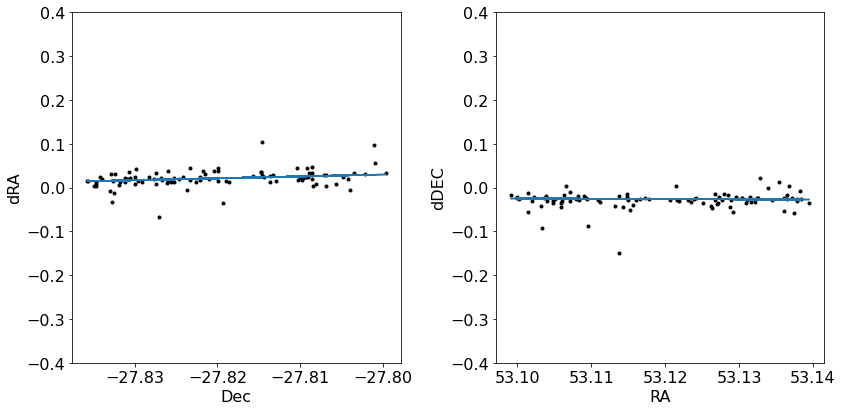

In [142]:
'''Checking the derived rotation, if necessary'''
fig, ax = plt.subplots(1, 2, figsize = (12, 6) )
ax[0].plot(tmp_coord_daofind[idx_daofind].dec, tmp_ra_offset, marker = '.', color = 'k', ls = 'none')
ax[0].set_ylim(-0.4, 0.4)


ax[1].plot(tmp_coord_daofind[idx_daofind].ra, tmp_dec_offset, marker = '.', color = 'k', ls = 'none')
ax[1].set_ylim(-0.4, 0.4)


poly_dec_dRA = optimize.curve_fit(f = linear, xdata = tmp_coord_daofind[idx_daofind].dec, ydata = tmp_ra_offset)[0]
poly_ra_dDEC = optimize.curve_fit(f = linear, xdata = tmp_coord_daofind[idx_daofind].ra, ydata = tmp_dec_offset)[0]
## iter-1
arg_dec_dRA = np.where(sigma_clip(np.polyval(poly_dec_dRA, tmp_coord_daofind[idx_daofind].dec.value) - tmp_ra_offset).mask == False)[0]
poly_dec_dRA = optimize.curve_fit(f = linear, xdata = tmp_coord_daofind[idx_daofind].dec[arg_dec_dRA], ydata = tmp_ra_offset[arg_dec_dRA])[0]
arg_ra_dDEC = np.where(sigma_clip(np.polyval(poly_ra_dDEC, tmp_coord_daofind[idx_daofind].ra.value) - tmp_dec_offset).mask == False)[0]
poly_ra_dDEC = optimize.curve_fit(f = linear, xdata = tmp_coord_daofind[idx_daofind].ra[arg_ra_dDEC], ydata = tmp_dec_offset[arg_ra_dDEC])[0]
## iter-2
arg_dec_dRA = np.where(sigma_clip(np.polyval(poly_dec_dRA, tmp_coord_daofind[idx_daofind].dec.value) - tmp_ra_offset).mask == False)[0]
poly_dec_dRA, pcov_dec_dRA = optimize.curve_fit(f = linear, xdata = tmp_coord_daofind[idx_daofind].dec[arg_dec_dRA], ydata = tmp_ra_offset[arg_dec_dRA])
arg_ra_dDEC = np.where(sigma_clip(np.polyval(poly_ra_dDEC, tmp_coord_daofind[idx_daofind].ra.value) - tmp_dec_offset).mask == False)[0]
poly_ra_dDEC, pccov_ra_dDEC = optimize.curve_fit(f = linear, xdata = tmp_coord_daofind[idx_daofind].ra[arg_ra_dDEC], ydata = tmp_dec_offset[arg_ra_dDEC])
perr_dec_dRA = np.sqrt(np.diag(pcov_dec_dRA))
perr_ra_dDEC = np.sqrt(np.diag(pccov_ra_dDEC))

ax[0].plot(tmp_coord_daofind[idx_daofind].dec.value, 
           np.polyval(poly_dec_dRA, tmp_coord_daofind[idx_daofind].dec.value))
ax[1].plot(tmp_coord_daofind[idx_daofind].ra.value, 
           np.polyval(poly_ra_dDEC, tmp_coord_daofind[idx_daofind].ra.value))
ax[0].set(xlabel = 'Dec', ylabel = 'dRA')
ax[1].set(xlabel = 'RA', ylabel = 'dDEC')
plt.tight_layout()

print(poly_dec_dRA, poly_ra_dDEC)

Write astrometric catalog if necessary. The one that I got for Ice Age data (F182M/F210M image & F444W grism) is available at [http://gxn.as.arizona.edu/~sunfengwu/grism_demo/PID_1895_SW_wavecal_obs001.dat](http://gxn.as.arizona.edu/~sunfengwu/grism_demo/PID_1895_SW_wavecal_obs001.dat). 

In [143]:
# ascii.write(tb_sw_astrometry, '/xdisk/egami/fengwusun/grism_demo/PID_1895_SW_wavecal_obs001.dat', 
#             overwrite = True)

In [144]:
# tb_sw_astrometry = ascii.read('/xdisk/egami/fengwusun/grism_demo/PID_1895_SW_wavecal_obs001.dat')

print('0-16-50-84-100 percentiles of astrometric accuracy for RA direction [in mas]:')
print(np.round(np.percentile(tb_sw_astrometry['dRA_err'].data / np.sqrt(tb_sw_astrometry['N_match'].data - 1), 
                             [0, 16, 50, 84, 100]) * 1e3, 2))

0-16-50-84-100 percentiles of astrometric accuracy for RA direction [in mas]:
[0.11 0.15 0.22 0.28 0.49]


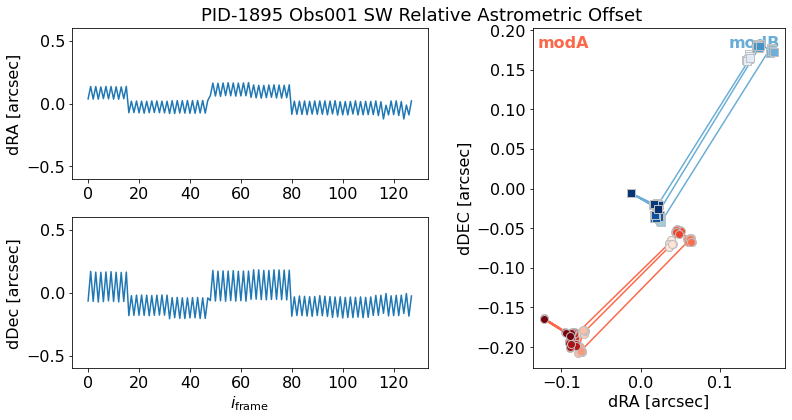

In [147]:
'''Evolution of astrometric offsets with exposures:'''
fig = plt.figure(constrained_layout = False, figsize = (12, 6))
ax_dict = fig.subplot_mosaic('''AACC
                                BBCC''')
ax_dict['A'].plot(tb_sw_astrometry['dRA']) # color =  plt.cm.Reds(0.5))
ax_dict['B'].plot(tb_sw_astrometry['dDEC']) # color =  plt.cm.Blues(0.5))
ax_dict['A'].set(ylabel = 'dRA [arcsec]', ylim = (-0.6, 0.6))
ax_dict['B'].set(ylabel = 'dDec [arcsec]', ylim = (-0.6, 0.6), xlabel = '$i_\mathrm{frame}$')

for i, tmp_dRA in enumerate(tb_sw_astrometry['dRA']):
    if i%2 == 0: # mod-A
        kwargs_dot = dict(color = plt.cm.Reds(i/len(tb_sw_astrometry)), marker = 'o', zorder = i)
    else:        # mod-B
        kwargs_dot = dict(color = plt.cm.Blues(i/len(tb_sw_astrometry)), marker = 's', zorder = i)
    ax_dict['C'].plot(tb_sw_astrometry['dRA'][i], tb_sw_astrometry['dDEC'][i], **kwargs_dot, 
                      mec = 'silver', mew = 1, ms = 8)
        
ax_dict['C'].plot(tb_sw_astrometry['dRA'][::2], tb_sw_astrometry['dDEC'][::2], 
                  ls = '-', color = plt.cm.Reds(0.5), zorder = 1)
ax_dict['C'].plot(tb_sw_astrometry['dRA'][1::2], tb_sw_astrometry['dDEC'][1::2], 
                  ls = '-', color = plt.cm.Blues(0.5), zorder = 0)
ax_dict['C'].set(aspect = 1, ylabel = 'dDEC [arcsec]', xlabel = 'dRA [arcsec]')
corner_text(ax_dict['C'], s = 'modA', color =  plt.cm.Reds(0.5), loc = 2, weight = 'semibold')
corner_text(ax_dict['C'], s = 'modB', color =  plt.cm.Blues(0.5), loc = 1, weight = 'semibold')
fig.text(0.5, 0.98, 'PID-1895 Obs001 SW Relative Astrometric Offset', ha = 'center', va = 'top', fontsize = 18)
plt.tight_layout()
plt.subplots_adjust(top = 0.93)
# fig.savefig('/xdisk/egami/fengwusun/grism_demo/PID_1895_SW_relative_astrom_001.pdf', dpi = 100)

[Text(0.5, 0, 'Exp NUM'), Text(0, 0.5, 'modA - modB OFFSET'), (-0.2, 0.5)]

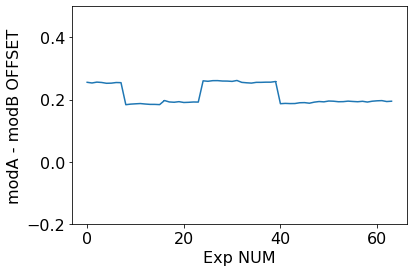

In [148]:
'''Astrometric offsets between module A and B'''
plt.errorbar(np.arange(len(tb_sw_astrometry)/2),
             ((tb_sw_astrometry['dRA'][::2] - tb_sw_astrometry['dRA'][1::2])**2 + 
              (tb_sw_astrometry['dDEC'][::2] - tb_sw_astrometry['dDEC'][1::2])**2)**0.5,
             yerr = tb_sw_astrometry['dDEC_err'][::2] * np.sqrt(2) / np.sqrt(tb_sw_astrometry['N_match'][::2] - 1),
         ls = '-', zorder = 0)
plt.gca().set(xlabel = 'Exp NUM', ylabel = 'modA - modB OFFSET', ylim = (-0.2, 0.5))

#### Check source position predicted by fits WCS + Measured Astrometry on SW images
This method will also be used to predict source positions on grism data

 12 >> /xdisk/egami/fengwusun/grism_demo/direct_imaging/jw01895001001_04101_00003_nrca2_cal.fits 


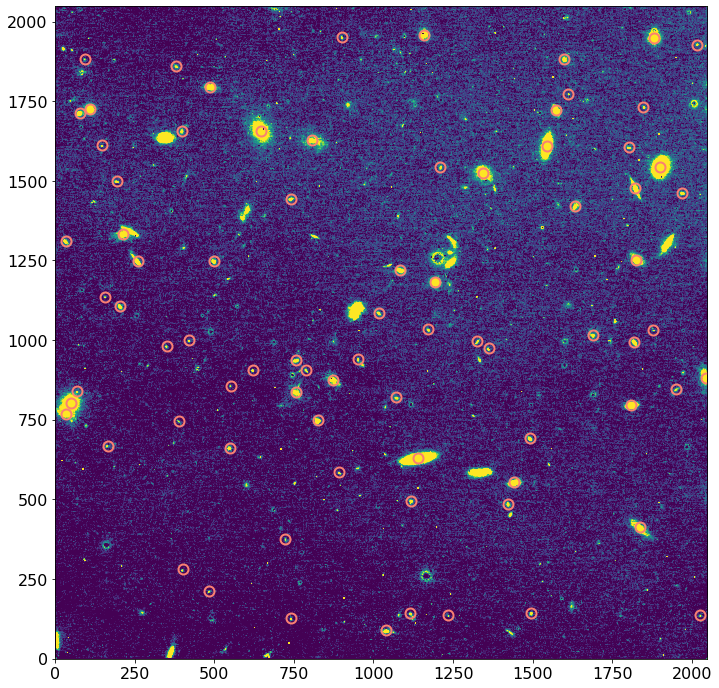

In [149]:
## Select one SW exposure to look at:
k = 12
tmp_img_cal_path = list_img_cal_this_band[k * 4 + 1]
tmp_img_cal_path_base = os.path.basename(tmp_img_cal_path)[:30]
## astrometric info:
item_sw_astrom = tb_sw_astrometry[tb_sw_astrometry['expName'] == tmp_img_cal_path_base][0]
print('%3d >> %s ' % (k, tmp_img_cal_path))
tmp_img_cal_hd = fits.getheader(tmp_img_cal_path, 0)
tmp_detector = tmp_img_cal_hd['DETECTOR'].lower()
tmp_img_cal_sci_hd = fits.getheader(tmp_img_cal_path, 'sci')
tmp_img_cal_wcs = wcs.WCS(tmp_img_cal_sci_hd)
time_obs = Time(tmp_img_cal_sci_hd['MJD-AVG'], format ='mjd')
tmp_detectors = np.array(['%s%d' % (tmp_detector[:-1], tmp_det) for tmp_det in [1, 2, 3, 4]])
tmp_img_cal_paths = np.array([tmp_img_cal_path.replace(tmp_detector, x) for x in tmp_detectors])
    
'''astrometric catalog loaded'''
tmp_coord_center = SkyCoord(tmp_img_cal_sci_hd['CRVAL1'], tmp_img_cal_sci_hd['CRVAL2'], unit = (u.deg, u.deg))
tmp_coord_LW = SkyCoord(tmp_RA, tmp_DEC, unit = (u.deg, u.deg))
tmp_coord_LW = tmp_coord_LW[tmp_coord_center.separation(tmp_coord_LW) < 2 * u.arcmin]
tmp_RA, tmp_DEC = tmp_coord_LW.ra.value, tmp_coord_LW.dec.value 
# tmp_RA, tmp_DEC = tb_LW['RA'].data, tb_LW['DEC'].data 
# tmp_RA, tmp_DEC = tb_LW['ALPHA_J2000'].data, tb_LW['DELTA_J2000'].data 
# tmp_RA_astrom = tmp_RA + item_sw_astrom['dRA'] / np.cos(np.deg2rad(tmp_DEC)) / 3600.
# tmp_DEC_astrom = tmp_DEC + item_sw_astrom['dDEC'] / 3600.
# tmp_img_cal_sci_hd['crval1'] -= item_sw_astrom['dRA'] / np.cos(np.deg2rad(tmp_img_cal_sci_hd['crval2'])) / 3600.
# tmp_img_cal_sci_hd['crval2'] -= item_sw_astrom['dDEC'] / 3600.
'''astrometric info applied on WCS:'''
tmp_cd_matrix = np.array([[tmp_img_cal_sci_hd['CD1_1'], tmp_img_cal_sci_hd['CD1_2']],
                          [tmp_img_cal_sci_hd['CD2_1'], tmp_img_cal_sci_hd['CD2_2']]])
tmp_rot_matrix = np.array([[np.cos(np.deg2rad(-item_sw_astrom['theta'])), - np.sin(np.deg2rad(-item_sw_astrom['theta']))],
                           [np.sin(np.deg2rad(-item_sw_astrom['theta'])),   np.cos(np.deg2rad(-item_sw_astrom['theta']))]])
tmp_cd_matrix = np.matmul(tmp_cd_matrix, tmp_rot_matrix)
tmp_img_cal_sci_hd['CD1_1'] = tmp_cd_matrix[0][0]
tmp_img_cal_sci_hd['CD1_2'] = tmp_cd_matrix[0][1]
tmp_img_cal_sci_hd['CD2_1'] = tmp_cd_matrix[1][0]
tmp_img_cal_sci_hd['CD2_2'] = tmp_cd_matrix[1][1]

                          
# ## Read latest SiAF for NIRCam
# nircam_siaf = pysiaf.Siaf('NIRCam')
# tmp_siaf = nircam_siaf['%s_%s' % (tmp_img_cal_hd['detector'], tmp_img_cal_hd['SUBARRAY'])]
# try: rotation = item_sw_astrom['theta']
# except KeyError: rotation = 0
    
'''
Convert coordinate of astrometric sources to pixel_x/y based on WCS
'''
plt.figure(figsize = (12, 12))
tmp_sci_img = fits.getdata(tmp_img_cal_path, 'sci')
plt.imshow(tmp_sci_img, vmin = np.nanpercentile(tmp_sci_img, 40), vmax = np.nanpercentile(tmp_sci_img, 98), origin = 'lower')


tmp_wcs = wcs.WCS(tmp_img_cal_sci_hd)
pixelx, pixely = wcs.utils.skycoord_to_pixel(SkyCoord(tmp_RA, tmp_DEC, unit = (u.deg, u.deg)), tmp_wcs)  
    
arg_gaia_plot = np.where((pixelx > 0) & (pixelx < 2048) & (pixely > 0) & (pixely < 2048))[0]
plt.plot(pixelx[arg_gaia_plot], pixely[arg_gaia_plot], marker = 'o', mfc = 'none', mec = 'salmon', ms = 10, ls = 'none', mew = 2)


# tmp_asdf_distortion = asdf.open(crds.getreferences(tmp_img_cal_hd, 
#                                                    reftypes = ['distortion'], ignore_cache = False)['distortion'])
# loc_v2, loc_v3 = tmp_asdf_distortion['model'](pixelx, pixely)
# pixelx, pixely = tmp_siaf.tel_to_sci(loc_v2, loc_v3) 
# plt.plot(pixelx[arg_gaia_plot], pixely[arg_gaia_plot], marker = 'o', mfc = 'none', mec = 'w', ms = 10, ls = 'none', mew = 2)

# plt.xlim(200, 700);plt.ylim(200, 700)
# plt.xlim(1300, 1800);plt.ylim(1300, 1800)

## 5. Genertae Source Catalog for each LW grism exposure


With astrometric information in hand, we can start to generate the catalog that include sources of our interest for each LW grism exposures. With these catalogs (I name them as "POM-applied catalogs" because POM selection effects are applied), you can then run the code blocks to extract 2D spectra from individual LW grism frames, co-add them together to produce the final 2D grism spectra. 

First of all, let us grab the reduced LW grism images (`_rate_lv1.5.fits`) again:


In [152]:
'''LW Grism images and corresponding astrometric information:'''
all_rate_list = glob.glob('/xdisk/egami/fengwusun/grism_demo/grism_cal/jw01895001*_rate_lv1.5.fits')
tb_sw_astrometry = ascii.read('/xdisk/egami/fengwusun/grism_demo/PID_1895_SW_wavecal_obs001.dat')

all_rate_list.sort()
all_rate_list = np.array(all_rate_list)
print(len(all_rate_list), 'wcs corrected fits files')

'''read filter, module and pupil'''
all_filters, all_module, all_pupil = [], [], []
all_roll_angle, all_target = [], []
for i, x in enumerate(all_rate_list):
    tmp_header = fits.getheader(x)
    all_filters.append(tmp_header['filter'])
    all_module.append(tmp_header['module'])
    all_pupil.append(tmp_header['pupil'])
    all_roll_angle.append(fits.getheader(x, 1)['ROLL_REF'])
    all_target.append(tmp_header['TARGPROP'])
all_filters, all_module, all_pupil = np.array(all_filters), np.array(all_module), np.array(all_pupil)
all_roll_angle, all_target = np.array(all_roll_angle), np.array(all_target)
print(np.unique(all_filters), np.unique(all_module), np.unique(all_target))

### change target prefix if you like:
tmp_filter = np.unique(all_filters)[0]
tmp_target = 'GDS'

128 wcs corrected fits files
['F444W'] ['A' 'B'] ['GOODS-S-CENTER']


FRESCO data consist of F444W grism spectra taken with both module A and B in opposite dispersion direction (see first plot in this notebook). In the following example, we input a [source catalog including a few known z=5-8 galaxies with strong emission line](http://gxn.as.arizona.edu/~sunfengwu/grism_demo/goods_s_interesting_emitter_demo.cat) as the master catalog for spectral extraction. The catalog is produced by Fengwu Sun & Jake Helton for the JADES collaboration.

In [156]:
'''Input master catalog for spectral extraction:'''
tb_f444w = ascii.read('/xdisk/egami/fengwusun/grism_demo/goods_s_interesting_emitter_demo.cat')
'''If necessary, select source based on morphology and brigtness'''

### read coordniates
coord_f444w = SkyCoord(tb_f444w['RA'], tb_f444w['DEC'], unit = (u.deg, u.deg))
print(len(coord_f444w), 'sources in total')


9 sources in total


In [158]:
'''Columnames of my catalog'''
print(tb_f444w.colnames)
tb_f444w[:100].show_in_notebook() #[:4] # ['ID'].data

['ID', 'RA', 'DEC', 'zspec', 'z_conf', 'zphot', 'z_a_v075', 'N_band', 'fit_flux_cgs', 'fit_flux_cgs_e', 'F444W_mag']


#### check source positions on top of FRESCO footprint


[53.05921161 53.19562679] [-27.87263016 -27.72960515]


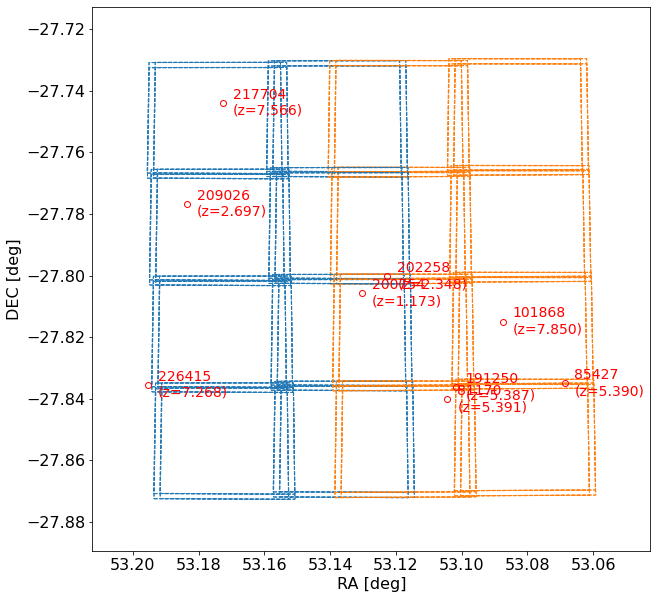

In [167]:
# coordinates in Science frame
sci_x = np.array([0, 2047, 2047, 0])
sci_y = np.array([0, 0, 2047, 2047])
sci_fullcov_A_x = sci_x # np.array([-100, 1300, 1300, -100])
sci_fullcov_B_x = sci_x # np.array([750, 2147, 2147, 750])

fig, ax = plt.subplots(1, 1, figsize = (10, 10))

for i, tmp_rate_path in enumerate(all_rate_list):
    tmp_module = fits.getheader(tmp_rate_path)['module']
    if tmp_module == 'A': 
        tmp_color = '#1f77b4'
        sci_x = sci_fullcov_A_x
    else: 
        tmp_color = '#ff7f0e'
        sci_x = sci_fullcov_B_x
    tmp_grism_hd_sci = fits.getheader(tmp_rate_path, 'sci')
    tmp_grism_hd_wcs = wcs.WCS(tmp_grism_hd_sci)
    coords_corners = wcs.utils.pixel_to_skycoord(sci_x, sci_y, tmp_grism_hd_wcs)
    coords_corners = np.array([coords_corners.ra.value, coords_corners.dec.value]).T
    line_fullcov = patches.Polygon(coords_corners, facecolor='none', ls = '--', ec = tmp_color,
                                   closed=True, alpha=1)
    ax.add_patch(line_fullcov)

    if i == 0: all_corners = coords_corners
    else: all_corners = np.vstack((all_corners, coords_corners))

### show sources
ax.plot(tb_f444w['RA'], tb_f444w['DEC'], marker = 'o', color = 'r', mfc = 'none', mew = 1, ls = 'none')
for i, item in enumerate(tb_f444w[:10]):
    ax.text(item['RA'] - 0.003, item['DEC'], s ='%d\n(z=%.3f)' % (item['ID'], item['zspec']), 
            ha = 'left', va = 'center', color = 'r', fontsize = 14)
### format axes
ax.set(xlim = (np.max(all_corners[:,0]) + 1/60, np.min(all_corners[:,0]) - 1/60),
       ylim = (np.min(all_corners[:,1]) - 1/60, np.max(all_corners[:,1]) + 1/60),
       xlabel = 'RA [deg]', ylabel = 'DEC [deg]'
      )
print(np.percentile(all_corners[:,0], [0, 100]), np.percentile(all_corners[:,1], [0, 100]))

#### For each exposure, apply astrometric correction and generate source catalog for spectral extraction

In this step, there is one tricky thing called **filter offset**. As you might have recalled, these offsets are introduced by different SW+LW filter combination. In commissioning, we used F212N + F444W for F444W grism spectroscopy, but FRESCO used F182M/F210M + F444W. Therefore, the spectral tracing model derived in commissioning could be offset from the actual ones in IceAge data due to the difference in SW filters. This should be a global shift (`dx`, `dy`) which is different for different modules but consistent for all exposures. I believe that this has not been well calibrated so far, so you will need to enter some `dx`, `dy` value manually. You can use the script a few blocks below the following code block to check the filter offsets in current CRDS, but my general advice is to change these `dx`, `dy` number manually after you successfully extract some 2D spectra and measure the real offsets. 


In [173]:
'''POM applied catalogs'''
### `all_rate_list`: a list of paths to the grism exposure fits files
for i, tmp_rate_path in enumerate(all_rate_list[:]):
    ''' 
    ## The following commands are used to read the astrometric offsets which is measured with SW detectors.
    ## In real life, the pointing accuracy of the telescope may not be stable and the absolute RA and DEC 
    ## offset can be floating. We will need to measure the astrometric shift from the SW exposures associated 
    ## with the grism exposures, and correct this factor for the RA and DEC in each source catalog associated 
    ## with the grism exposures. 
    '''
    tmp_rate_path_base = tmp_rate_path.split('/')[-1].split('long_rate')[0]
    print('[%3d]' % i, tmp_rate_path_base)
    
    tmp_grism_hd_1st = fits.getheader(tmp_rate_path, 0)
    tmp_grism_hd_sci = fits.getheader(tmp_rate_path, 'sci')
    
    tmp_filter = tmp_grism_hd_1st['filter']
    tmp_loc_v2, tmp_loc_v3 = tmp_grism_hd_sci['V2_REF'], tmp_grism_hd_sci['V3_REF']
    ### for different grism filters, read different catalog
    list_coords, tb_sex = coord_f444w, tb_f444w
        
    # if tmp_grism_hd_1st['filter'] != 'F444W': continue
    
    '''Accurate RA & Dec of Direct-Imaging sources  '''
    tmp_RA, tmp_DEC = list_coords.ra.to(u.deg).value, list_coords.dec.to(u.deg).value
    ### if the catalog is gaia star, considering proper motion:
    # time_obs = Time(tmp_grism_hd_sci['MJD-AVG'], format ='mjd')
    # dRA = ((time_obs - time_gaia).to(u.yr).value * tb_gaia['pmRA'].data * u.mas / np.cos(np.deg2rad(tb_gaia['DE_ICRS']))).to(u.deg).value
    # dDec = ((time_obs - time_gaia).to(u.yr).value * tb_gaia['pmDE'].data * u.mas).to(u.deg).value
    # tmp_RA, tmp_DEC = tb_gaia['RA_ICRS'].data.data + dRA, tb_gaia['DE_ICRS'].data.data + dDec
    '''Apply astrometric error measured on SW images'''
    item_sw_astrom = tb_sw_astrometry[tb_sw_astrometry['expName'] == tmp_rate_path_base]
    if len(item_sw_astrom) > 0:
        ## if there is astrometric information, consider that
        item_sw_astrom = item_sw_astrom[0]
        tmp_grism_hd_sci['CRVAL1'] -= item_sw_astrom['dRA'] / np.cos(np.deg2rad(tmp_grism_hd_sci['CRVAL2'])) / 3600.
        tmp_grism_hd_sci['CRVAL2'] -= item_sw_astrom['dDEC'] / 3600. 
        tmp_cd_matrix = np.array([[tmp_grism_hd_sci['CD1_1'], tmp_grism_hd_sci['CD1_2']],
                                  [tmp_grism_hd_sci['CD2_1'], tmp_grism_hd_sci['CD2_2']]])
        tmp_rot_matrix = np.array([[np.cos(np.deg2rad(-item_sw_astrom['theta'])), - np.sin(np.deg2rad(-item_sw_astrom['theta']))],
                                   [np.sin(np.deg2rad(-item_sw_astrom['theta'])),   np.cos(np.deg2rad(-item_sw_astrom['theta']))]])
        tmp_cd_matrix = np.matmul(tmp_cd_matrix, tmp_rot_matrix)
        tmp_grism_hd_sci['CD1_1'] = tmp_cd_matrix[0][0]
        tmp_grism_hd_sci['CD1_2'] = tmp_cd_matrix[0][1]
        tmp_grism_hd_sci['CD2_1'] = tmp_cd_matrix[1][0]
        tmp_grism_hd_sci['CD2_2'] = tmp_cd_matrix[1][1]
        tmp_RA_astrom = tmp_RA # + item_sw_astrom['dRA'] / np.cos(np.deg2rad(tmp_DEC)) / 3600.
        tmp_DEC_astrom = tmp_DEC # + item_sw_astrom['dDEC'] / 3600.
    else:
        ## if no astrometric information avaialble, skip this step and directly use RA and DEC
        print('Warning: No SW images found for %s, skip astrom correction! ' % tmp_rate_path_base)
        tmp_RA_astrom = tmp_RA 
        tmp_DEC_astrom = tmp_DEC 
    try: rotation = item_sw_astrom['theta']
    except KeyError: rotation = 0
    
    '''RA/DEC to grism-frame x and y'''
    tmp_grism_wcs = wcs.WCS(tmp_grism_hd_sci)
    idx_this_field = np.where((np.abs((tmp_RA_astrom - tmp_grism_hd_sci['crval1']) * np.cos(np.deg2rad(tmp_grism_hd_sci['crval2']))) < 3 / 60.) &
                              (np.abs(tmp_DEC_astrom - tmp_grism_hd_sci['crval2']) < 3 / 60.))[0]
    pixelx, pixely  = wcs.utils.skycoord_to_pixel(SkyCoord(tmp_RA_astrom[idx_this_field], 
                                                           tmp_DEC_astrom[idx_this_field], unit = (u.deg, u.deg)), 
                                                  tmp_grism_wcs)
    '''This is the place to add small offsets from all kind of reasons (e.g., filter offset)'''
    if tmp_grism_hd_1st['module'] == 'A' : dx, dy = 2.0, 0  ###  +2.0, -2.5
    else: dx, dy = 0, 0
    pixelx, pixely = pixelx + dx, pixely + dy
    tb_sex = tb_sex[idx_this_field]
    if len(tb_sex) == 0: continue

    '''for DAOFIND-based catalog '''
    if 'F444W_mag' in tb_sex.colnames: tmp_mag_auto = tb_sex['F444W_mag'].data
    elif 'F160W_mag' in tb_sex.colnames: tmp_mag_auto = tb_sex['F160W_mag'].data
    tb_pom_applied = Table(data = [tb_sex['ID'].data, 
                                   tmp_RA[idx_this_field], tmp_DEC[idx_this_field], 
                                   pixelx, pixely, tmp_mag_auto,], # tmp_magerr_auto, tb_sex['flags']
                           names = ['Index', 'ra', 'dec', 'pixel_x', 'pixel_y', 'MAG_AUTO']) # , 'MAGERR_AUTO', 'FLAGS'
    # arg_is_pickoff = np.where(is_pickoff(pixelx, pixely, module = tmp_grism_hd_1st['module']))[0]
    arg_is_pickoff = np.where(is_pickoff_PS(pixelx, pixely, module = tmp_grism_hd_1st['module'], 
                                            filter = tmp_grism_hd_1st['filter'], pupil = tmp_grism_hd_1st['pupil'][-1]) > 0.05)[0]
    tb_pom_applied = tb_pom_applied[arg_is_pickoff]
    tb_pom_applied['ra'].info.format = '.6f'
    tb_pom_applied['dec'].info.format = '.6f'
    tb_pom_applied['pixel_x'].info.format = '.3f'
    tb_pom_applied['pixel_y'].info.format = '.3f'
    tb_pom_applied['MAG_AUTO'].info.format = '.3f'
    try:
        tb_pom_applied['MAGERR_AUTO'].info.format = '.3f'
        tb_pom_applied['A_IMAGE'].info.format = '.3f'
        tb_pom_applied['B_IMAGE'].info.format = '.3f'
        tb_pom_applied['THETA_IMAGE'].info.format = '.2f'
        tb_pom_applied['CLASS_STAR'].info.format = '.3f'
    except KeyError: pass
    # print(tb_pom_applied)
    '''Change the path of catalogs to be saved:'''
    path_tb_pom_applied = '/xdisk/egami/fengwusun/grism_demo/POM_catalog/' +  tmp_rate_path_base + '_%s_dirimg_sources.list' % tmp_filter
    if i == 0:
        if os.path.isdir(os.path.dirname(path_tb_pom_applied)) == False:
            os.mkdir(os.path.dirname(path_tb_pom_applied))
    ascii.write(tb_pom_applied, path_tb_pom_applied, overwrite = True)

[  0] jw01895001001_02101_00001_nrca
[  1] jw01895001001_02101_00001_nrcb
[  2] jw01895001001_02101_00002_nrca
[  3] jw01895001001_02101_00002_nrcb
[  4] jw01895001001_02101_00003_nrca
[  5] jw01895001001_02101_00003_nrcb
[  6] jw01895001001_02101_00004_nrca
[  7] jw01895001001_02101_00004_nrcb
[  8] jw01895001001_04101_00001_nrca
[  9] jw01895001001_04101_00001_nrcb
[ 10] jw01895001001_04101_00002_nrca
[ 11] jw01895001001_04101_00002_nrcb
[ 12] jw01895001001_04101_00003_nrca
[ 13] jw01895001001_04101_00003_nrcb
[ 14] jw01895001001_04101_00004_nrca
[ 15] jw01895001001_04101_00004_nrcb
[ 16] jw01895001002_02101_00001_nrca
[ 17] jw01895001002_02101_00001_nrcb
[ 18] jw01895001002_02101_00002_nrca
[ 19] jw01895001002_02101_00002_nrcb
[ 20] jw01895001002_02101_00003_nrca
[ 21] jw01895001002_02101_00003_nrcb
[ 22] jw01895001002_02101_00004_nrca
[ 23] jw01895001002_02101_00004_nrcb
[ 24] jw01895001002_04101_00001_nrca
[ 25] jw01895001002_04101_00001_nrcb
[ 26] jw01895001002_04101_00002_nrca
[

#### Optional: Check filter offset:

This should have been corrected in stage-2 using STScI CRDS files. However, I stil see some offsets in modA, weird!

In [174]:
### select a reduced grism exposure:
tmp_rate_path = all_rate_list[0]
tmp_rate_path_base = tmp_rate_path.split('/')[-1].split('long_rate')[0]
### SW header
tmp_sw_cal_path = os.path.dirname(tmp_rate_path) + '/../direct_imaging/' + tmp_rate_path_base + '1_cal.fits'
tmp_sw_cal_hd = fits.getheader(tmp_sw_cal_path)
### LW header
tmp_grism_hd_1st = fits.getheader(tmp_rate_path, 0)
### offsets in LW & SW
tmp_tb_foff_lw = Table(asdf.open(crds.getreferences(tmp_grism_hd_1st)['filteroffset'])['filters'])
tmp_tb_foff_sw = Table(asdf.open(crds.getreferences(tmp_sw_cal_hd)['filteroffset'])['filters'])
### Filter offset of  F212N, which is used in Commissioning
item_F212N = tmp_tb_foff_sw[(tmp_tb_foff_sw['filter'] == 'F212N') & (tmp_tb_foff_sw['pupil'] == tmp_sw_cal_hd['pupil'])][0]
### Filter offset of the filter used in the current SW exposures
item_sw = tmp_tb_foff_sw[(tmp_tb_foff_sw['filter'] == tmp_sw_cal_hd['filter']) & (tmp_tb_foff_sw['pupil'] == tmp_sw_cal_hd['pupil'])][0]

In [175]:
item_F212N, item_sw
# tmp_tb_foff_sw[(tmp_tb_foff_sw['filter'] == 'F200W') & (tmp_tb_foff_sw['pupil'] == tmp_sw_cal_hd['pupil'])][0]

(<Row index=0>
 column_offset filter pupil row_offset
    float64     str6   str8  float64  
 ------------- ------ ----- ----------
        -0.084  F212N CLEAR      0.044,
 <Row index=0>
 column_offset filter pupil row_offset
    float64     str6   str8  float64  
 ------------- ------ ----- ----------
           0.0  F210M CLEAR        0.0)

In [177]:
# '''Sometimes LW filters also introduce offset (e.g., F356W - F322W2). Check that if necessary'''
# tmp_tb_foff_lw[(tmp_tb_foff_lw['filter'] == 'F356W') & (tmp_tb_foff_lw['pupil'] == 'CLEAR')]

## 6. 2D Spectral Extraction

The following step is to extract grism spectra with the POM-applied catalogs and reduced grism data you produced above. At this step, you will need to load the following functions:

1. **Spectral Tracing Model**

Now we assume $(x_0, y_0)$ are direct imaging source position, $(x_s, y_s)$ are spectral pixel position at wavelength $\lambda_s$, and $dx = x_s - x_0$, $dy = y_s - y_0$. The spectral tracing model gives $dy(x_0, y_0, dx)$, i.e., the spectral tracing. The following plot shows the spectral tracing that we derived for F322W2 module A grism R using the commissioning data taken for the LMC field. Red squares are direct imaging positions of sources taken in multiple exposures, and black points are the corresponding spectral traces (curvature is exaggerated). The plot of `dx` versus `dy`, color-coded by the source position, is shown on the right. Note the spectra with $dx \sim 1000$ are second-order, which have not been fully characterized at this step.

![spectral tracing in F322W2 modA grismR](media/spectral_tracing_F322W2_modA_R.jpg)

The spectral tracing function is defined as `fit_disp_order23()` (see the beginning of this notebook). The best-fit parameters for these functions in different filter/module/grism can be found at [http://gxn.as.arizona.edu/~sunfengwu/home/data/dy_dx_tracing_model/](http://u.arizona.edu/~fengwusun/data/dy_dx_tracing_model/). For filters at 2.5-4.0 µm (e.g., F356W), please simply use the models for F322W2; for filters at 4.0-5.0µm (e.g., F410M), please use the models for F444W. 

These models have a typical accuracy of RMS<0.1 pixel if astrometric and filter offsets are corrected. Below is a plot showing the $dy(dx=0)$ map for F444W module A grism R. The dy of my model is color-coded as the background image, and squares with filled colors is what I directly measured from the spectral traces in the LMC field. You can see a field variation of $dy(dx=0)$ of 1-2 pixel, which has been well modeled with my spectral tracing function.

![dy(dx=0) map for F444W module A grism R](media/FS_trace_DY_map_F444W_A_R.jpg)

2. **Grism Dispersion model**

The grism dispersion models give the relation of $dx(x_0, y_0, \lambda_s)$, i.e., the dispersion at given wavelength for source at $(x_0, y_0)$. In the commissioning, this was characterized by the F322W2 and F444W spectra of post-AGB star [IRAS 05248-7007](http://simbad.u-strasbg.fr/simbad/sim-id?Ident=LHA+120-N+133) in the LMC field. 


The grism dispersion function is defined as `fit_disp_order32()` (or `func_fit_wave()`; see the beginning of this notebook). The best-fit parameters for these functions in different filter/module/grism can be found at [http://gxn.as.arizona.edu/~sunfengwu/home/data/dx_wave_dispersion_model/](http://gxn.as.arizona.edu/~sunfengwu/home/data/dx_wave_dispersion_model/). The function for the same grism + module combination applies for all filters.

The accuracy of wavelength calibration is on the order of RMS=0.1-0.2 pixel. However, I would like to note that the current wavelength calibration data is still quite limited (~200 data points fit for a 16-parameter functions), and I would expect the accuracy gets further improved with cycle-1 calibration program. 

3. **Sensitivity Function**

All of the grism transmission curves that I have produced are available at [http://gxn.as.arizona.edu/~sunfengwu/home/data/sensitivity_model/](http://gxn.as.arizona.edu/~sunfengwu/home/data/sensitivity_model/). These files were derived using the Cycle-1 WFSS flux cal observations obtained in September, 2022. All of the grism R flux calibration is based on a G dwarf (P330-E; PID: 1538), a white dwarf (G191-B2B; PID: 1537) and an A-type star (J1743045; PID: 1536) with six exposures in total. The C grism observation of the white dwarf is corrupted by nearby stars, so most of the flux calibration of grism C is only based on P330E and J1743045 (4 individual integrations in total). The derived grism sensitivity functions in all filter+grism+module combinations are shown as follows:

![overall sensitivity curve](media/overall_sensitivity_curve.jpg)


The three columns of each grism sensitivity table are wavelength (in µm), sensitivity (in DN/s/Jy/pixel) and uncertainty of sensitivity. The sensitivity is the total throughput (OTE * QE * filter * grism, etc.) and sums the counts across the perpendicular (i.e. spatial) direction of the spectral trace, so it is in unit of DN/s/Jy/pixel. The dispersion is around 0.97 nm/pixel, so it is possible to convert the sensitivity to those in unit like (DN/s)/(erg/s/cm^2/Å)/nm. Note that the dispersion (nm/pixel or Å/pixel) is a function of wavelength and direct imaging position $(x0, y0)$, but 0.97 nm/pixel is a good characteristic dispersion.


#### Load the grism tracing/dispersion/sensitivity functions and POM-applied catalogs:

In [179]:
### select the filter that we will work on:
tmp_filter = 'F444W'
list_coords, tb_sex = coord_f444w, tb_f444w

### Interested wavelength Range
if tmp_filter == 'F444W': WRANGE = np.array([3.8, 5.1])
# elif tmp_filter == 'F322W2': WRANGE = np.array([2.4, 4.1])
# elif tmp_filter == 'F356W':  WRANGE = np.array([3.1, 4.0])
# elif tmp_filter == 'F277W':  WRANGE = np.array([2.4, 3.1])

### Spectral tracing parameters:
# if tmp_filter in ['F277W', 'F335M', 'F322W2', 'F356W', 'F360M']: disp_filter = 'F322W2'
# elif tmp_filter in ['F410M', 'F444W', 'F480M']: disp_filter = 'F444W' 
disp_filter = tmp_filter
# dir_wavecal = '/home/u24/fengwusun/Comissioning/FS_grism_config_v2_202208/'
tb_order23_fit_AR = ascii.read('./data/FSun_cal/DISP_%s_mod%s_grism%s.dat' % (disp_filter, 'A', 'R'))
fit_opt_fit_AR, fit_err_fit_AR = tb_order23_fit_AR['col0'].data, tb_order23_fit_AR['col1'].data
tb_order23_fit_BR = ascii.read('./data/FSun_cal/DISP_%s_mod%s_grism%s.dat' % (disp_filter, 'B', 'R'))
fit_opt_fit_BR, fit_err_fit_BR = tb_order23_fit_BR['col0'].data, tb_order23_fit_BR['col1'].data
tb_order23_fit_AC = ascii.read('./data/FSun_cal/DISP_%s_mod%s_grism%s.dat' % (disp_filter, 'A', 'C'))
fit_opt_fit_AC, fit_err_fit_AC = tb_order23_fit_AC['col0'].data, tb_order23_fit_AC['col1'].data
tb_order23_fit_BC = ascii.read('./data/FSun_cal/DISP_%s_mod%s_grism%s.dat' % (disp_filter, 'B', 'C'))
fit_opt_fit_BC, fit_err_fit_BC = tb_order23_fit_BC['col0'].data, tb_order23_fit_BC['col1'].data

### grism dispersion parameters:
tb_fit_displ_AR = ascii.read('./data/FSun_cal/DISPL_mod%s_grism%s.dat' % ('A', "R"))
w_opt_AR, w_err_AR = tb_fit_displ_AR['col0'].data, tb_fit_displ_AR['col1'].data
tb_fit_displ_BR = ascii.read('./data/FSun_cal/DISPL_mod%s_grism%s.dat' % ('B', "R"))
w_opt_BR, w_err_BR = tb_fit_displ_BR['col0'].data, tb_fit_displ_BR['col1'].data
tb_fit_displ_AC = ascii.read('./data/FSun_cal/DISPL_mod%s_grism%s.dat' % ('A', "C"))
w_opt_AC, w_err_AC = tb_fit_displ_AC['col0'].data, tb_fit_displ_AC['col1'].data
tb_fit_displ_BC = ascii.read('./data/FSun_cal/DISPL_mod%s_grism%s.dat' % ('B', "C"))
w_opt_BC, w_err_BC = tb_fit_displ_BC['col0'].data, tb_fit_displ_BC['col1'].data

### list of module/pupil and corresponding tracing/dispersion function:
list_mod_pupil   = np.array(['AR', 'BR', 'AC', 'BC'])
list_fit_opt_fit = np.array([fit_opt_fit_AR, fit_opt_fit_BR, fit_opt_fit_AC, fit_opt_fit_BC])
list_w_opt       = np.array([w_opt_AR, w_opt_BR, w_opt_AC, w_opt_BC])

### Sensitivity curve:
dir_fluxcal = './data/FSun_cal/'
# dir_fluxcal = '/home/u24/fengwusun/Comissioning/cycle1_cal_program/fluxcal/product/'
tb_sens_AR = ascii.read(dir_fluxcal + '%s_mod%s_grism%s_sensitivity.dat' % (tmp_filter, 'A', 'R'))
tb_sens_BR = ascii.read(dir_fluxcal + '%s_mod%s_grism%s_sensitivity.dat'% (tmp_filter, 'B', 'R'))
tb_sens_AC = ascii.read(dir_fluxcal + '%s_mod%s_grism%s_sensitivity.dat' % (tmp_filter, 'A', 'C'))
tb_sens_BC = ascii.read(dir_fluxcal + '%s_mod%s_grism%s_sensitivity.dat'% (tmp_filter, 'B', 'C'))
f_sens_AR = interpolate.UnivariateSpline(tb_sens_AR['wavelength'], tb_sens_AR['DN/s/Jy'], ext = 'zeros', k = 1, s = 1e2)
f_sens_BR = interpolate.UnivariateSpline(tb_sens_BR['wavelength'], tb_sens_BR['DN/s/Jy'], ext = 'zeros', k = 1, s = 1e2)
f_sens_AC = interpolate.UnivariateSpline(tb_sens_AC['wavelength'], tb_sens_AC['DN/s/Jy'], ext = 'zeros', k = 1, s = 1e2)
f_sens_BC = interpolate.UnivariateSpline(tb_sens_BC['wavelength'], tb_sens_BC['DN/s/Jy'], ext = 'zeros', k = 1, s = 1e2)
list_f_sens       = (f_sens_AR, f_sens_BR, f_sens_AC, f_sens_BC)

'''list of source list (POM-applied catalog)'''
list_sl = glob.glob('/xdisk/egami/fengwusun/grism_demo/POM_catalog/jw*_nrc[a-b]_%s_dirimg_sources.list' % tmp_filter)
list_sl.sort()
list_rate_this = np.array([os.path.dirname(all_rate_list[0]) + '/' + os.path.basename(list_sl[i]).split('_%s' % tmp_filter)[0] + 'long_rate_lv1.5.fits' 
                           for i in range(len(list_sl))])


Index_interest = tb_sex['ID'].data
print(len(Index_interest), 'sources selected')
list_sl_table = [ascii.read(x) for x in list_sl]


''' 
Generate two dictionaries which record the grism frame ID and path for each source to be extracted
'''
grism_frame_ID_per_source = dict()   # dictionary of the ID of exposure (0-95) for each source (0-5000+)
grism_frame_path_per_source = dict() # dictionary of the path of exposure (*/jw*.fits) for each source (0-5000+)
for idx in Index_interest[:]:
    grism_frame_ID_per_source['%s' % idx] = []
    grism_frame_path_per_source['path_%s' % idx] = []
for i, tmp_sl_table in enumerate(list_sl_table):
    for idx in tmp_sl_table['Index'].data:
        # try:
        grism_frame_ID_per_source['%s' % idx].append(i)
        grism_frame_path_per_source['path_%s' % idx].append(list_rate_this[i])
        # except KeyError: continue
N_frame_per_source = np.array([len(grism_frame_ID_per_source[x]) for x in grism_frame_ID_per_source.keys()])
print('%d sources may yield spectra' % (np.sum(N_frame_per_source > 0)))

9 sources selected
9 sources may yield spectra


In [180]:
tb_f444w[N_frame_per_source >= 2][:100].show_in_notebook()

#### The following functions are used to extract 2d spectra, resample / coadd 2d spectra and save them.

In [181]:
def extract_2d_spec(img, WRANGE, x0, y0, dxs, dys, wave, img_wht, img_dq, header, 
                    img_line = None, aper = 10., pupil = 'R', n_procs = 4):
    '''
    Extract 2D spectrum from the Grism Image
    -----------------------------------------------
        Parameters
        ----------
        img : `~numpy.ndarray`
            2D dispersed slitless spectroscopic image
        
        GConf: `~grismconf.grismconf.Config`
            Configuration file of grism (taken from `grismconf`)
            
        x0, y0 : float
            Reference position (i.e., in direct image)
        
        dxs, dys : `~numpy.ndarray`
            First derivative of the trace x/y-coordinates with respect to 't' (taken from `grismconf`)
        
        wave: 
            Wavelength of extracted spectrum
            
        img_wht : `~numpy.ndarray`
            Weighting image (1/rms^2) of `img`
            
        img_dq : `~numpy.ndarray`
            DQ (data-quality) image (1/rms^2) of `img`
            
        header: `fits.Header()` object
            Header of 2D dispersed slitless spectroscopic image
        
        img_line : None or `~numpy.ndarray`
            EMLINE (scientific) image, continuum-subtracted version of `img`
            
        aper: float
            Aperture radius for 2D spectra extraction (unit: arcsec, default: 1.25)
        
        pix_scale: float
            Pixel scale in unit of arcsec. If None then computed from header
        
        pupil: 'R' or 'C'
            pupil of grism ('R' or 'C')
            
        Returns
        -------
        hdul : `~astropy.io.fits.HDUList()` object
            The fits files of extracted 2D spectra, including a primary frame, a sci frame,
                (scientific), a wht frame (weighting) and a dq frame (data quality).
    '''
    w_min, w_max = WRANGE
    x_on_G_img = dxs + x0
    y_on_G_img = dys + y0
    
    if pupil not in ['C', 'R']: raise KeyError('pupil of grism should be either "R" or "C"! ')
    
    aper_int_pix = int(aper)
    
    
    ### region that we can extract spectra: 
    if pupil == 'R':
        args_eff = np.where((wave >= w_min) & (wave <= w_max) 
                            & (x_on_G_img >= 5) & (x_on_G_img <= 2047 - 6)
                            & (y_on_G_img >= aper_int_pix) & (y_on_G_img <= 2047 - 6 - aper_int_pix) )
    elif pupil == 'C':
        args_eff = np.where((wave >= w_min) & (wave <= w_max) 
                            & (x_on_G_img >= aper_int_pix) & (x_on_G_img <= 2047 - 6 - aper_int_pix)
                            & (y_on_G_img >= 5) & (y_on_G_img <= 2047 - 6) )
    if np.size(args_eff) <= 20:  ## spectrum is too short
        raise ValueError('No spectrum can be extracted from the 2D Image')
    tmp_spec_2d = np.zeros((len(args_eff[0]), aper_int_pix*2+1))
    tmp_wht_2d = np.zeros((len(args_eff[0]), aper_int_pix*2+1))
    tmp_dq_2d = np.zeros((len(args_eff[0]), aper_int_pix*2+1))
    # if img_line != None: 
    tmp_line_2d = np.zeros((len(args_eff[0]), aper_int_pix*2+1))
        
    for i, j in enumerate(args_eff[0]):
        if pupil == 'R':
            tmp_x, tmp_y1, tmp_y2 = int(x_on_G_img[j]), int(y_on_G_img[j] - aper_int_pix - 1), int(y_on_G_img[j] + aper_int_pix + 2)
            img.T[tmp_x, tmp_y1:tmp_y2] = ndimage.shift(img.T[tmp_x, tmp_y1:tmp_y2], -(y_on_G_img[j]%1), order = 1, mode ='wrap')
            img_wht.T[tmp_x, tmp_y1:tmp_y2] = ndimage.shift(img_wht.T[tmp_x, tmp_y1:tmp_y2], -(y_on_G_img[j]%1), order = 1, mode ='wrap')
            img_dq.T[tmp_x, tmp_y1:tmp_y2] = ndimage.shift(img_dq.T[tmp_x, tmp_y1:tmp_y2], -(y_on_G_img[j]%1), order = 1, mode ='wrap')
            tmp_spec_2d[i] = img.T[tmp_x][tmp_y1+1:tmp_y2-1]
            tmp_wht_2d[i] = img_wht.T[tmp_x][tmp_y1+1:tmp_y2-1]
            tmp_dq_2d[i] = img_dq.T[tmp_x][tmp_y1+1:tmp_y2-1]
            # if img_line != None: 
            img_line.T[tmp_x, tmp_y1:tmp_y2] = ndimage.shift(img_line.T[tmp_x, tmp_y1:tmp_y2], -(y_on_G_img[j]%1), order = 1, mode ='wrap')
            tmp_line_2d[i] = img_line.T[tmp_x][tmp_y1+1:tmp_y2-1]
        elif pupil == 'C':
            tmp_y, tmp_x1, tmp_x2 = int(y_on_G_img[j]), int(x_on_G_img[j] - aper_int_pix - 1), int(x_on_G_img[j] + aper_int_pix + 2)
            img[tmp_y, tmp_x1:tmp_x2] = ndimage.shift(img[tmp_y, tmp_x1:tmp_x2], -(x_on_G_img[j]%1), order = 1, mode ='wrap')
            img_wht[tmp_y, tmp_x1:tmp_x2] = ndimage.shift(img_wht[tmp_y, tmp_x1:tmp_x2], -(x_on_G_img[j]%1), order = 1, mode ='wrap')
            img_dq[tmp_y, tmp_x1:tmp_x2] = ndimage.shift(img_dq[tmp_y, tmp_x1:tmp_x2], -(x_on_G_img[j]%1), order = 1, mode ='wrap')
            tmp_spec_2d[i] = img[tmp_y, tmp_x1+1:tmp_x2-1]
            tmp_wht_2d[i] = img_wht[tmp_y, tmp_x1+1:tmp_x2-1]
            tmp_dq_2d[i] = img_dq[tmp_y, tmp_x1+1:tmp_x2-1]
            # if img_line != None: 
            img_line[tmp_y, tmp_x1:tmp_x2] = ndimage.shift(img_line[tmp_y, tmp_x1:tmp_x2], -(x_on_G_img[j]%1), order = 1, mode ='wrap')
            tmp_line_2d[i] = img[tmp_y, tmp_x1+1:tmp_x2-1]
    
    tmp_spec_2d = tmp_spec_2d.T
    tmp_wht_2d = tmp_wht_2d.T
    tmp_dq_2d = tmp_dq_2d.T
    # if img_line != None: 
    tmp_line_2d = tmp_line_2d.T
        
    '''Construct fits file for 2d grism spectra'''
    ### Primary HDU
    hdu = fits.PrimaryHDU()
    hdu.header['x0'] = (np.float32(x0), 'Reference position X in direct image')
    hdu.header['y0'] = (np.float32(y0), 'Reference position Y in direct image')
    # tmp_coord = wcs.utils.pixel_to_skycoord(x0, y0, tmp_wcs)
    # hdu.header['RA0'] = (tmp_coord.ra.value, 'Reference position RA in direct image')
    # hdu.header['DEC0'] = (tmp_coord.dec.value, 'Reference position Dec in direct image')
    hdu.header['author'] = ('Fengwu Sun', 'Author of this file')
    hdu.header['time'] = (time.strftime("%Y/%m/%d %H:%M:%S",  time.localtime()), 'Time of Creation')
    ### Scientific HDU
    hdu_sci = fits.ImageHDU(np.float32(tmp_spec_2d), name = 'SPEC2D')
    hdu_sci.header['wave_1'] = (wave[args_eff[0][1]], 'Wavelength (um) of first pixel')
    hdu_sci.header['d_wave'] = (np.mean(np.diff(wave[args_eff[0]])), 'Wavelength Difference (um) between each pixel')
    hdu_sci.header['comments'] = ('wave = wave_1 + np.arange(0, NAXIS1, 1) * d_wave')
    hdu_sci.header['aperture'] = (aper, 'Aperture radius in undispersed direction (arcsec)')
    hdu_sci.header['pupil'] = (pupil, 'Pupil of grism (R or C)')
    hdu_sci.header['module'] = (header['module'], 'Module of Detector (A or B)')
    hdu_sci.header['diff_y'] = (y_on_G_img[args_eff[0]][0], 'Y_(full)-Y_(trim)')
    hdu_sci.header['diff_x'] = (x_on_G_img[args_eff[0]][0], 'X_(full)-X_(trim)')
    ### Weight HDU
    hdu_wht = fits.ImageHDU(np.float32(tmp_wht_2d), name = 'WHT2D')
    ### Data-quality HDU
    hdu_dq = fits.ImageHDU(np.int32(tmp_dq_2d), name = 'DQ2D')
    ### Line-only HDU:
    # if img_line != None:
    hdu_line = hdu_sci.copy()
    hdu_line.header['EXTNAME'] = 'LINE2D'
    hdu_line.data = np.float32(tmp_line_2d)
    hdu_line.header['comments'] = 'extracted from continuum subtracted map'
    ### Tracing & Dispersion information
    tmp_tb_wave = Table(data = [wavs[args_eff], x_on_G_img[args_eff], y_on_G_img[args_eff], dxs[args_eff], dys[args_eff]],
                    names = ['wavelength', 'xs', 'ys', 'dxs', 'dys'])
    tmp_tb_wave['wavelength'].info.format = '.6f'
    for x in tmp_tb_wave.colnames[1:]: tmp_tb_wave[x].info.format = '.3f'
    hdul = fits.HDUList([hdu, hdu_sci, hdu_wht, hdu_dq])
    # if img_line != None:  
    hdul.append(hdu_line)
    hdul.append(fits.BinTableHDU(tmp_tb_wave, name = 'WAVE'))
    return hdul


def store_all_2d_spec(fits_list, pupils, modules, paths, output = 'test.fits',
                      coord = None, filter = None, info_table = None, overwrite = True):
    '''
    Write all the individual 2D spectra of one single sources into a fits file
    -----------------------------------------------
    Parameters
        ----------  
        fits_list : list of `astropy.io.fits`
            list of fits files generated by extract_2d_spec()
        
        pupils: list of strings
            pupil list of grism ('R' or 'C')
        
        modules: list of strings
            module list of NIRCam detector ('A' or 'B')
        
        paths: list of strings
            paths of grism exposures
        
        output: string
            Output file name
        
        coord: `astropy.coordinates.SkyCoord` object
            coordinates of the source. default: None (will not record this in the header)
        
        filter: string
            Filter of grism observation (e.g., 'F444W', 'F332W', 'F356W')
            default: None (will not record this in the header)
        
        info_table: astropy.table.Row
            A row of information related to this source
            default: None (will not record this in the header)
            
        overwrite: bool
            If true, save (and overwrite) the data. default: True
            
        Returns
        -------
        ind_hdul: `~astropy.io.fits.HDUList`
            fits HDU list of individual sci, wht and dq data.
            
    '''
    ## HDU list of individual exposures:
    ind_hdul = fits.HDUList([fits.PrimaryHDU()])
    for l, x in enumerate(fits_list):
        ind_hdul.append(x[1]) 
        ind_hdul[-1].header['EXTNAME'] = 'SPEC2D-%d' % l
        for card_name in ['x0', 'y0']: # 'ra0', 'dec0']:
            ind_hdul[-1].header[card_name] = x[0].header[card_name]
        ind_hdul[-1].header['pupil'] = pupils[l]
        ind_hdul[-1].header['module'] = modules[l]
        ind_hdul[-1].header['datapath'] = paths[l].split('/')[-1]
        ind_hdul.append(x[2]) 
        ind_hdul[-1].header['EXTNAME'] = 'WHT2D-%d' % l
        ind_hdul.append(x[3])
        ind_hdul[-1].header['EXTNAME'] = 'DQ2D-%d' % l
        if len(x) == 5:  # no line image extension
            ind_hdul.append(x[4])
            ind_hdul[-1].header['EXTNAME'] = 'WAVE-%d' % l
        else:            # with line image extension
            ind_hdul.append(x[4])
            ind_hdul[-1].header['EXTNAME'] = 'LINE2D-%d' % l
            ind_hdul.append(x[5])
            ind_hdul[-1].header['EXTNAME'] = 'WAVE-%d' % l
    #### stats of single exposures
    ind_hdul.append(fits.BinTableHDU(Table(names = ['id', 'pupil', 'module', 'datapath'], # 'POM', 
                                           data = [range(len(fits_list)), pupils, modules, # poms,
                                                   [tmp_path.split('/')[-1] for tmp_path in paths]]),
                                     name = 'STATS'))
    #### add other important specs
    ind_hdul[0].header['DIRNAME'] = (os.path.dirname(paths[0]), 'Directory name of original grism data')
    if coord != None:
        ind_hdul[0].header['RA0'] = (tmp_coord.ra.value, 'Reference position RA in direct image')
        ind_hdul[0].header['DEC0'] = (tmp_coord.dec.value, 'Reference position Dec in direct image')
    ind_hdul[0].header['N_coadd'] = (len(ind_hdul[-1].data['pupil']), 'Number of coadded frames')
    ind_hdul[0].header['N_R'] = (np.sum(ind_hdul[-1].data['pupil'] == 'R'), 'Number of R grism frames')
    ind_hdul[0].header['N_C'] = (np.sum(ind_hdul[-1].data['pupil'] == 'C'), 'Number of C grism frames')
    ind_hdul[0].header['author'] = ('Fengwu Sun', 'Author of this file')
    ind_hdul[0].header['time'] = (time.strftime("%Y/%m/%d %H:%M:%S",  time.localtime()), 'Time of Creation')
    if filter != None:
        ind_hdul[0].header['filter'] = (tmp_filter, 'Filter name')
    if info_table != None:
        ind_hdul[0].header['COMMENTS'] = 'Belows are information taken from input catalog:'
        for x in info_table.colnames:
            if type(info_table[x]) == np.ma.core.MaskedConstant: continue
            elif type(info_table[x]) != np.str_ : 
                if np.isnan(info_table[x]) : ind_hdul[0].header['HIERARCH ' + x] = 'nan' 
                elif np.isinf(info_table[x]) : ind_hdul[0].header['HIERARCH ' + x] = 'inf' 
                else: ind_hdul[0].header['HIERARCH ' + x] = info_table[x]
            else: ind_hdul[0].header['HIERARCH ' + x] = info_table[x]
    if overwrite: ind_hdul.writeto(output, overwrite = overwrite) ## save the fits file?
    return ind_hdul

def resample_spec2d_wmin_wmax(x, i):
    '''
    Resample a series of 2D spectra at wavelegth range = tmp_w_min - tmp_w_max
    -----------------------------------------------
    Parameters
        ---------- 
        x: int
            index of the individual fits files in the list.
        
        i: int
            index of the resampled wave array
        
        tmp_wave_2d: 
            Global variable (`list(np.array())`). 
            A compilation of 1D wavelength array associated with all individual grism frames.
        
        tmp_ind_fits_list:
            Global variable (`astropy.io.fits.HDUList()`). 
            A HDU List that have extracted 2D spectra (SCI/WHT/DQ) from each individual frames
            
        wave_sample:
            Global variable (`np.array()`)
            Resampled wavelengths. 
            
        Returns
        -------
        tmp_spec_w_1: `~np.array()`
            a column of 2D SCI spectra from frame [x] that fall in the resampled wavelength range [i]
        
        tmp_wht_w_1: `~np.array()`
            a column of 2D WHT spectra at the same position as that of `tmp_spec_w_1`
        
        tmp_cov_w_1: `~np.array()`
            a column of 2D DQ spectra at the same position as that of `tmp_spec_w_1`
    '''
    global tmp_wave_2d, tmp_ind_fits_list, wave_sample # arrays to use
    # global arr_spec_2d, arr_wht_2d, arr_cov_2d         # arrays to save; impossible with pool
    tmp_w_min, tmp_w_max = wave_sample[i], wave_sample[i+1]
    ## resampled SCI, WHT, DQ image
    arg_in_wmin_wmax = tuple([(tmp_wave_2d[x] > tmp_w_min) & (tmp_wave_2d[x] <= tmp_w_max)])
    tmp_spec_w = tmp_ind_fits_list[x][1].data.T[arg_in_wmin_wmax]
    tmp_wht_w = np.nan_to_num(tmp_ind_fits_list[x][2].data.T[arg_in_wmin_wmax], posinf = 0, neginf = 0)
    tmp_dq_w = tmp_ind_fits_list[x][3].data.T[arg_in_wmin_wmax]
    if len(tmp_ind_fits_list[x]) == 5: tmp_line_w = tmp_ind_fits_list[x][1].data.T[arg_in_wmin_wmax]
    else: tmp_line_w = tmp_ind_fits_list[x][4].data.T[arg_in_wmin_wmax]  ## line map 
    # tmp_wht_w[tmp_dq_w!=0] = 0    ### strict dq: reject all dq != 0:
    tmp_wht_w[tmp_dq_w%2==1] = 0    ### loose dq: only remove do not use pixel:
    ## stack/resample N spectra at wmin-wmax (M rows)
    tmp_spec_w_1 = np.nansum(tmp_spec_w * tmp_wht_w, axis = 0) / np.nansum(tmp_wht_w, axis = 0) #/ sum_tmp_wht_w #
    tmp_wht_w_1 = np.nansum(tmp_wht_w, axis = 0)
    tmp_cov_w_1 = np.int8(tmp_wht_w_1 != 0)
    tmp_line_w_1 = np.nansum(tmp_line_w * tmp_wht_w, axis = 0) / np.nansum(tmp_wht_w, axis = 0) #/ sum_tmp_wht_w #
    ## save resampled spectra to array
    # arr_spec_2d[i, x], arr_wht_2d[i, x], arr_cov_2d[i, x] = tmp_spec_w_1, tmp_wht_w_1, tmp_cov_w_1
    return(tmp_spec_w_1, tmp_wht_w_1, tmp_cov_w_1, tmp_line_w_1)

#### Extract 2D grism spectra with the loop below:

In [182]:
'''Choose extraction mode:
all : R + C combined
  R : R only
  C : C only
'''

extract_mode = 'all'   # all, R, C
start = time.time()

extract_path = '/xdisk/egami/fengwusun/grism_demo/extract_2d/'
if os.path.isdir(extract_path) == False: os.mkdir(extract_path)

for i, idx in enumerate(Index_interest[:]):
    '''
    Read source information from the input catalog 
    '''
    t_a = time.time()
    ## item_sex = tb_sex[tb_sex['NUMBER'] == idx][0]
    ## tmp_mag = item_sex['MAG_AUTO']
    item_sex = tb_sex[tb_sex['ID'] == idx][0]
    if 'F444W_mag' in tb_sex.colnames: tmp_mag = item_sex['F444W_mag']
    elif 'F160W_mag' in tb_sex.colnames: tmp_mag = item_sex['F160W_mag']
    tmp_coord = SkyCoord(item_sex['RA'], item_sex['DEC'], unit = (u.deg, u.deg))
    ### tmp_coord = SkyCoord(item_sex['X_WORLD'], item_sex['Y_WORLD'], unit = (u.deg, u.deg))
    print('-[%3d] ID%s mag=%.2f' % (i, idx, tmp_mag), end = " ")
    '''
    ### if no record of grism exposure is found in the dict `grism_frame_ID_per_source`, 
    ###    the script will continue to save time
    '''
    if len(grism_frame_ID_per_source[str(idx)]) == 0: print(' >> no spec found; '); continue
    else:
        ## find 2D grism image, get the list
        this_list_rate_wcs = np.array(grism_frame_path_per_source['path_'+str(idx)])
        this_ID_rate_wcs = np.array(grism_frame_ID_per_source[str(idx)])  
    # print('[%d spectra]' % len(this_list_rate_wcs))
    ### but, if the number of available frame is too small, we will skip the extraction
    # if len(grism_frame_ID_per_source[str(idx)]) <= 2: print(' >> no spec found; '); continue
    
    
    '''
    Examine each reduced image to extract 2D spectra
    '''
    tmp_ind_fits_list = []
    tmp_ind_fits_name_list = []
    tmp_ind_module_list = []
    tmp_ind_pupil_list = []
    tmp_ind_pom_list = []
    for j, tmp_grism in enumerate(this_list_rate_wcs):
        ### `tmp_grism` is the path of grism data ('*/jw*.fits')
        # if idx not in list_sl_table[j]['Index'] : continue  ## legacy command
        ### `tmp_idx_grism` is the sequential number of grism data (like 0-95 with 96 frames)
        tmp_idx_grism = this_ID_rate_wcs[j]  
        tmp_grism_img        = fits.getdata(tmp_grism, 'sci')        ### Grism SCI image data
        try:
            tmp_grism_img_emline = fits.getdata(tmp_grism, 'emline') ### Line-only Grism SCI image data
        except KeyError:
            tmp_grism_img_emline = tmp_grism_img
        tmp_grism_dq         = fits.getdata(tmp_grism, 'dq')         ### Grism DQ data 
        tmp_grism_hd         = fits.getheader(tmp_grism)             ### Grism primary Header
        tmp_filter, tmp_module, tmp_pupil = tmp_grism_hd['filter'], tmp_grism_hd['module'], tmp_grism_hd['pupil'][-1]
        ### depending on `extract_mode`, only extrac R/C data
        if extract_mode.lower() == 'r': 
            if tmp_pupil == 'C' : continue
        if extract_mode.lower() == 'c': 
            if tmp_pupil == 'R' : continue
        tmp_grism_hd_sci = fits.getheader(tmp_grism, 'sci')  ### Grism SCI Header
        ### Read or Generate Grism WHT data:
        tmp_grism_wht_path = tmp_grism.replace('lv1.5.fits', 'wht.fits')
        if os.path.isfile(tmp_grism_wht_path): 
            tmp_grism_wht = fits.getdata(tmp_grism_wht_path)
        else:
            ### 2D grism WHT file not found, generate from Error map:
            tmp_grism_err = fits.getdata(tmp_grism, 'err')
            tmp_grism_err[tmp_grism_err == 0] = np.nan
            tmp_grism_wht = tmp_grism_err**-2
            tmp_grism_wht_hdul = fits.HDUList([fits.PrimaryHDU(), fits.ImageHDU(tmp_grism_wht, name = 'WHT')])
            tmp_grism_wht_hdul[1].header = tmp_grism_hd_sci
            tmp_grism_wht_hdul.writeto(tmp_grism_wht_path, overwrite = True)
            tmp_grism_wht_hdul.close()
        ### Direct imaging positions 
        item_sl = list_sl_table[tmp_idx_grism][list_sl_table[tmp_idx_grism]['Index'] == idx][0]
        x0 = item_sl['pixel_x']
        y0 = item_sl['pixel_y']
        print('%s(%.1f, %.1f) ' % (tmp_pupil, x0, y0), end = ' ')
        ### spectral tracing parameters
        fit_opt_fit = list_fit_opt_fit[list_mod_pupil == tmp_module + tmp_pupil][0]
        w_opt       = list_w_opt[list_mod_pupil == tmp_module + tmp_pupil][0]
        dxs, dys, wavs = grism_conf_preparation(x0 = x0,  y0 = y0, pupil = tmp_pupil, 
                                                fit_opt_fit = fit_opt_fit, w_opt = w_opt)
        tmp_aper = 15.                                   # common aperture size 
        ### Extract 2D spectrum on each single frame
        try:
            tmp_ind_fits = extract_2d_spec(img = tmp_grism_img, WRANGE = WRANGE, 
                                           x0 = x0, y0 = y0, dxs = dxs, dys = dys,
                                           wave = wavs, img_wht = tmp_grism_wht, img_dq = tmp_grism_dq,
                                           img_line = tmp_grism_img_emline, ## add EMLINE extension
                                           header = tmp_grism_hd, pupil = tmp_pupil, aper = tmp_aper)
        except ValueError:
            continue
        tmp_ind_fits_list.append(tmp_ind_fits)
        tmp_ind_module_list.append(tmp_module)
        tmp_ind_fits_name_list.append(tmp_grism)
        tmp_ind_pupil_list.append(tmp_pupil)
        
    ### If no spectra can be extract, continue; else: save spectra of all individal extraction
    if len(tmp_ind_fits_list) == 0: 
        print(' >> no spec found; ')
        continue
    else: 
        print(' >> N=%d, x0=%.1f, y0=%.1f' % (len(tmp_ind_fits_list), x0, y0), end = '')
        if extract_mode.lower() not in ['r', 'c']:
            '''Change the path of saved 2D spectra: '''
            tmp_ind_specs_name = extract_path + '/allspec_2d_%s_%s_ID%s.fits' % (tmp_target, tmp_filter, idx)
            store_all_2d_spec(fits_list = tmp_ind_fits_list, pupils = tmp_ind_pupil_list, 
                              modules = tmp_ind_module_list, paths = tmp_ind_fits_name_list, 
                              output = tmp_ind_specs_name, coord = tmp_coord, 
                              filter = tmp_filter,  info_table = item_sex, overwrite = True)
            print(' >> save all extracted spec2d ', end = '')
    ### Correct for sensitivity:
    for k, tmp_fits in enumerate(tmp_ind_fits_list[:]):
        tmp_modpup = tmp_fits[1].header['MODULE'] + tmp_fits[1].header['PUPIL']
        tmp_f_sens = list_f_sens[np.where(list_mod_pupil == tmp_modpup)[0][0]]
        if len(tmp_fits) == 5:  tmp_wavelength = tmp_fits[4].data['wavelength']
        else: # if has a line map
            tmp_wavelength = tmp_fits[5].data['wavelength'] 
            tmp_ind_fits_list[k][4].header['bunit'] = ('mJy', 'Brightness Unit')
            tmp_ind_fits_list[k][4].data = tmp_fits[4].data / tmp_f_sens(tmp_wavelength) * 1e3 # to unit of mJy
        tmp_ind_fits_list[k][1].header['bunit'] = ('mJy', 'Brightness Unit')
        tmp_ind_fits_list[k][1].data = tmp_fits[1].data / tmp_f_sens(tmp_wavelength) * 1e3     # to unit of mJy
        tmp_ind_fits_list[k][2].data = tmp_fits[2].data * tmp_f_sens(tmp_wavelength)**2 * 1e-6
    '''
    Combine 2D spectra from all extraction
    '''
    tmp_wave_2d = np.array([x[-1].data['wavelength'] for x in tmp_ind_fits_list], dtype = object)
    ### resampled to the following wavelength frame:
    d_wave = 0.001
    wave_sample = np.arange(WRANGE[0], WRANGE[1] + d_wave, d_wave)
    wave_sample_c = wave_sample[:-1] + d_wave / 2.
    arr_spec_2d = np.zeros((len(wave_sample)-1, len(tmp_wave_2d), len(tmp_ind_fits_list[0][1].data)))
    arr_wht_2d  = np.zeros_like(arr_spec_2d)
    arr_cov_2d  = np.zeros_like(arr_spec_2d)
    arr_line_2d = np.zeros_like(arr_spec_2d)  ## line map
    np.seterr(invalid = 'ignore')
    ### New method: resample spectrum using a multiple-processing tool:
    xx, ii = np.meshgrid(range(len(tmp_wave_2d)), range(len(wave_sample) - 1))
    xx = xx.flatten()
    ii = ii.flatten()
    with Pool(np.min([8, len(xx)])) as pool:
        output = pool.starmap(resample_spec2d_wmin_wmax,  zip(xx, ii))
    for o in range(len(output)):
        i, x = ii[o], xx[o] 
        arr_spec_2d[i, x], arr_wht_2d[i, x], arr_cov_2d[i, x], arr_line_2d[i, x] = output[o]
    ## sigma clip spectra SED 
    tmp_sigma_clip = SigmaClip(sigma_lower = 2.0, sigma_upper = 3.0)
    arg_sigclip = np.where(tmp_sigma_clip(np.nanmean(arr_spec_2d, axis = (0, 2))).mask == False)[0]
    tmp_ind_fits_list = [tmp_ind_fits_list[x] for x in arg_sigclip]
    tmp_ind_module_list = np.array(tmp_ind_module_list)[arg_sigclip]
    tmp_ind_fits_name_list = np.array(tmp_ind_fits_name_list)[arg_sigclip]
    arr_spec_2d = arr_spec_2d[:,arg_sigclip,:]
    arr_wht_2d  = arr_wht_2d[:,arg_sigclip,:]
    arr_cov_2d  = arr_cov_2d[:,arg_sigclip,:]
    arr_line_2d = arr_line_2d[:,arg_sigclip,:]
    ## new: sigma clip
    sigma_clip = SigmaClip(sigma = 4.)
    arr_spec_2d = sigma_clip(arr_spec_2d, axis = 1, masked = False)
    arr_line_2d = sigma_clip(arr_line_2d, axis = 1, masked = False)
    arr_wht_2d[np.where(np.isnan(arr_spec_2d))] = 0
    arr_wht_2d[np.where(np.isnan(arr_line_2d))] = 0
    ## weighted mean 2d spectra:
    tmp_spec_2d = np.nansum(arr_spec_2d * arr_wht_2d, axis = 1) / np.nansum(arr_wht_2d, axis = 1) # sum_arr_wht_2d # 
    tmp_wht_2d = np.nansum(arr_wht_2d, axis = 1)
    tmp_cov_2d = np.nansum(arr_cov_2d, axis = 1)
    tmp_line_2d = np.nansum(arr_line_2d * arr_wht_2d, axis = 1) / np.nansum(arr_wht_2d, axis = 1) # sum_arr_wht_2d # 
    '''
    Save Coadded 2D spectra
    '''
    tmp_tb_cov = Table(names = ['index', 'name', 'x0', 'y0', 'module', 'pupil', 'DIFF_X', 'DIFF_Y', 'wave_0', 'wave_1'],
                       data = [range(len(tmp_ind_fits_list)),
                               [tmp_grism.split('/')[-1][:-16] for tmp_grism in tmp_ind_fits_name_list],
                               [x[0].header['x0'] for x in tmp_ind_fits_list],
                               [x[0].header['y0'] for x in tmp_ind_fits_list],
                               tmp_ind_module_list,
                               [x[1].header['PUPIL'] for x in tmp_ind_fits_list],
                               [x[1].header['DIFF_X'] for x in tmp_ind_fits_list],
                               [x[1].header['DIFF_Y'] for x in tmp_ind_fits_list],
                               [np.round(wave_sample_c[np.sum(arr_wht_2d, axis = -1)[:, n_] != 0][0], 4) 
                                for n_ in range(len(tmp_ind_fits_list))],
                               [np.round(wave_sample_c[np.sum(arr_wht_2d, axis = -1)[:, n_] != 0][-1], 4) 
                                for n_ in range(len(tmp_ind_fits_list))],
                              ]) 
    
    hdu = fits.PrimaryHDU()
    hdu.header['RA0'] = (tmp_coord.ra.value, 'Reference position RA in direct image')
    hdu.header['DEC0'] = (tmp_coord.dec.value, 'Reference position Dec in direct image')
    hdu.header['N_coadd'] = (len(tmp_tb_cov['pupil']), 'Number of coadded frames')
    hdu.header['N_R'] = (np.sum(tmp_tb_cov['pupil'] == 'R'), 'Number of R grism frames')
    hdu.header['N_C'] = (np.sum(tmp_tb_cov['pupil'] == 'C'), 'Number of C grism frames')
    hdu.header['author'] = ('Fengwu Sun', 'Author of this file')
    hdu.header['time'] = (time.strftime("%Y/%m/%d %H:%M:%S",  time.localtime()), 'Time of Creation')
    hdu.header['filter'] = (tmp_filter, 'Filter name')
    # hdu.header['abmag'] = (tmp_mag, 'AB Magnitude in %s Band' % tmp_filter)
    hdu.header['COMMENTS'] = 'Belows are information taken from input catalog:'
    for x in item_sex.colnames:
        if type(item_sex[x]) == np.ma.core.MaskedConstant: continue
        elif type(item_sex[x]) != np.str_ : 
            if np.isnan(item_sex[x]) : hdu.header['HIERARCH ' + x] = 'nan' 
            elif np.isinf(item_sex[x]) : hdu.header['HIERARCH ' + x] = 'inf' 
            else: hdu.header['HIERARCH ' + x] = item_sex[x]
        else: hdu.header['HIERARCH ' + x] = item_sex[x]
    hdu_sci = fits.ImageHDU(tmp_spec_2d.T, name = 'SPEC2D')
    hdu_sci.header['wave_1'] = (wave_sample_c[0], 'Wavelength (um) of first pixel')
    hdu_sci.header['d_wave'] = (wave_sample_c[1] - wave_sample_c[0], 'Wavelength Difference (um) between each pixel')
    hdu_sci.header['comments'] = ('wave = wave_1 + np.arange(0, NAXIS1, 1) * d_wave')
    hdu_sci.header['pixscale'] = (0.0629, 'Pixel scale in undispersed direction (arcsec)')
    hdu_sci.header['aperture'] = (tmp_aper, 'Aperture radius in undispersed direction (pixel)')
    ### weight extension
    hdu_wht = fits.ImageHDU(tmp_wht_2d.T, name = 'WHT2D')
    hdu_wht.header['comments'] = ('Weight image; ERR = WHT^(-0.5)')
    ### number of coverage per pixel extension
    hdu_cov = fits.ImageHDU(tmp_cov_2d.T, name = 'COV2D')
    hdu_cov.header['comments'] = ('Coverage image')
    ### line-only SCI extension
    hdu_line = hdu_sci.copy()
    hdu_line.data = tmp_line_2d.T
    hdu_line.header['extname'] = 'LINE2D'
    hdu_line.header['comments'] = ('Line-only image extracted on continuum-filtered 2D data')
    ### statistics tab
    hdu_tab = fits.BinTableHDU(tmp_tb_cov, name = 'STATS')
    hdu_tab.header['COMMENT'] = 'name:     name of simulated image'
    hdu_tab.header['COMMENT'] = 'x0 / y0:  reference position (i.e., in direct image)'
    hdu_tab.header['COMMENT'] = '   (in reality this is registered to the wcs of grism image)'
    hdu_tab.header['COMMENT'] = 'DIFF_X:   X_(full)-X_(trim)'
    hdu_tab.header['COMMENT'] = 'DIFF_Y:   Y_(full)-Y_(trim)'
    hdu_tab.header['COMMENT'] = 'wave_0:   minimum wavelength (micron) in this coverage'
    hdu_tab.header['COMMENT'] = 'wave_1:   maximum wavelength (micron) in this coverage'
    hdul = fits.HDUList([hdu, hdu_sci, hdu_wht, hdu_cov, hdu_line, hdu_tab])
    '''Change the path of saved 2D spectra: '''
    tmp_spec_2d_name = extract_path + 'spec_2d_%s_%s_ID%s_comb.fits' % (tmp_target, tmp_filter,  idx)
    if extract_mode.lower() in ['r', 'c']: 
        tmp_spec_2d_name = tmp_spec_2d_name.replace('_comb.fits', '_%s.fits' % extract_mode.upper())
    hdul.writeto(tmp_spec_2d_name, overwrite = True)
    print(' >> save stacked spec2d; ')

end = time.time()
print('run time = %.1fs = %.1fmin' % (end - start, (end - start)/60))

-[  0] ID101868 mag=25.98 R(671.1, 1140.7)  R(667.6, 1235.7)  R(763.1, 1239.1)  R(766.6, 1144.0)  R(671.1, 1140.7)  R(667.5, 1235.7)  R(763.1, 1239.1)  R(766.5, 1144.0)   >> N=8, x0=766.5, y0=1144.0 >> save all extracted spec2d  >> save stacked spec2d; 
-[  1] ID217704 mag=25.55 R(1060.1, 1298.1)  R(1056.9, 1393.7)  R(1152.9, 1396.8)  R(1156.0, 1301.4)  R(1060.1, 1298.1)  R(1056.9, 1393.7)  R(1152.9, 1396.9)  R(1156.0, 1301.4)   >> N=8, x0=1156.0, y0=1301.4 >> save all extracted spec2d  >> save stacked spec2d; 
-[  2] ID226415 mag=24.81 R(-56.9, 124.8)  R(-52.4, 30.9)  R(-56.9, 124.8)  R(-52.4, 30.8)   >> N=2, x0=-52.4, y0=30.8 >> save all extracted spec2d  >> save stacked spec2d; 
-[  3] ID81170 mag=25.24 R(1627.6, 1706.4)  R(1624.8, 1802.3)  R(1721.1, 1804.7)  R(1723.9, 1708.9)  R(1627.6, 1706.4)  R(1624.8, 1802.3)  R(1721.1, 1804.7)  R(1723.9, 1708.9)   >> N=8, x0=1723.9, y0=1708.9 >> save all extracted spec2d  >> save stacked spec2d; 
-[  4] ID85427 mag=25.69 R(1611.2, 95.1)  R(170

### 7. Examine 2D & 1D spectra in plots

With the 2D grism spectra you just extracted and combined above, it is now the time to examine the quality of extracted spectra. You can plot the 2D, 1D spectrum and direct imaging data in the same frame.

In [186]:
'''List of 2D co-added grism spectra that we just extracted:'''
list_spec = np.array(glob.glob('/xdisk/egami/fengwusun/grism_demo/extract_2d/spec_2d_*_comb.fits'))
list_spec.sort()
print(len(list_spec), 'spectra files in total.')

'''Direct imaging data 
   for FRESCO data, the F444W direct imaging data is avaialble at:
        http://gxn.as.arizona.edu/~sunfengwu/grism_demo/GOODS-S_lw_F444W_modall_i2d.fits
   You can also use other images released by the FRESCO team: 
        https://archive.stsci.edu/hlsp/fresco
'''
path_LW = '/xdisk/egami/fengwusun/grism_demo/GOODS-S_lw_F444W_modall_i2d.fits'
img_LW = fits.getdata(path_LW, 1); hd_LW =  fits.getheader(path_LW, 1); band_LW = 'F444W'
wcs_LW = wcs.WCS(hd_LW)
pix_LW = wcs.utils.proj_plane_pixel_area(wcs_LW) ** 0.5 * 3600.

9 spectra files in total.


0 101868 F444W_mag=25.98


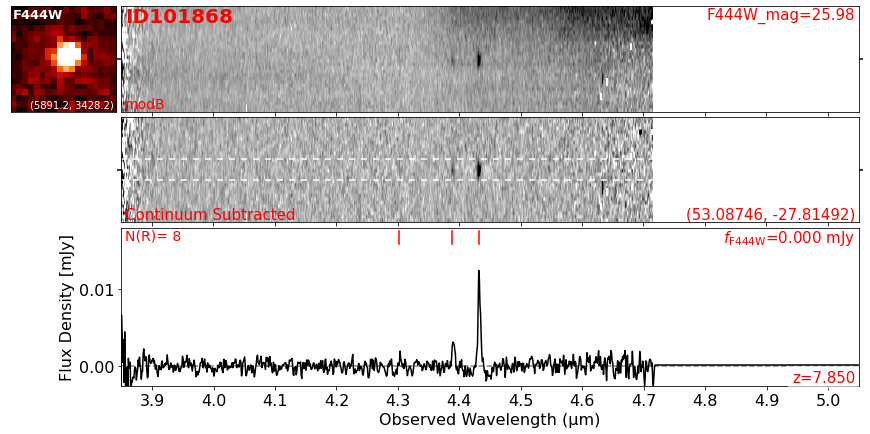

In [265]:

for i, tmp_spec_path in enumerate(list_spec[:1]):
    tmp_spec_fits = fits.open(tmp_spec_path)
    '''source information '''
    tmp_id = tmp_spec_fits[0].header['ID']        
    tmp_filter = tmp_spec_fits[0].header['FILTER'] 
    if 'F444W_mag' in np.concatenate(np.array(tmp_spec_fits[0].header.cards)):
        mag_keyword = 'F444W_mag'
    elif 'F160W_mag' in np.concatenate(np.array(tmp_spec_fits[0].header.cards)):
        mag_keyword = 'F160W_mag'
    tmp_mag = tmp_spec_fits[0].header[mag_keyword]  
    if tmp_mag == 'nan': tmp_mag = 99.; tmp_spec_fits[0].header[mag_keyword] = 99.
    tmp_flux_mJy = 10**(-0.4 * tmp_spec_fits[0].header[mag_keyword]) * 3631e3 # 10**(-0.4 * tmp_spec_fits[0].header['MAG_AUTO']) * 3631e3 
    if mag_keyword == '1mm_mag': tmp_flux_mJy = tmp_mag
    tmp_N_R = tmp_spec_fits[0].header['N_R']
    tmp_N_C = tmp_spec_fits[0].header['N_C']
    tmp_tb_stats = Table(tmp_spec_fits['STATS'].data)
    tmp_N_A, tmp_N_B = np.sum(tmp_tb_stats['module'] == 'A'), np.sum(tmp_tb_stats['module'] == 'B')
    tmp_RA, tmp_DEC = tmp_spec_fits[0].header['RA0'], tmp_spec_fits[0].header['DEC0']
    tmp_x0, tmp_y0 = wcs.utils.skycoord_to_pixel(SkyCoord(tmp_RA, tmp_DEC, unit = (u.deg, u.deg)), wcs_LW)
    
    ### extract spectra from images with continuum?
    is_cont = False
    # is_cont = True
    
    '''2d spec'''
    tmp_spec_2d = tmp_spec_fits['spec2d'].data
    tmp_line_2d = tmp_spec_fits['line2d'].data
    tmp_wht_2d  = tmp_spec_fits['wht2d'].data
    wave_sample_c = tmp_spec_fits[1].header['WAVE_1'] + np.arange(tmp_spec_fits[1].header['NAXIS1']) * tmp_spec_fits[1].header['D_WAVE']
    
    ## vertical median filter??
#     L_box, L_mask = 8, 2
#     mf_footprint = np.ones((L_box * 2 + 1, 1))
#     mf_footprint[L_box-L_mask:L_box+L_mask+1,:] = 0
#     tmp_spec_2d = tmp_spec_2d - ndimage.median_filter(tmp_spec_2d, footprint = mf_footprint, mode = 'reflect')
#     L_box, L_mask = 2, 0
#     mf_footprint = np.ones((1, L_box * 2 + 1))
#     mf_footprint[:,L_box-L_mask:L_box+L_mask+1] = 0
#     tmp_spec_2d = ndimage.median_filter(tmp_spec_2d, footprint = mf_footprint, mode = 'reflect')


    ## if not enough wavelength coverage, then skip
    if np.sum(np.isnan(np.nansum(tmp_spec_2d, axis = 0)) == False) < 200: continue
        
    ## get y center:
    tmp_spec_ydir = np.nansum(tmp_spec_2d * tmp_wht_2d, axis = 1) / np.nansum(tmp_wht_2d, axis = 1)
    # tmp_yc   = np.argmax(tmp_spec_ydir[12:19]) + 12
    tmp_yc   = 15
    tmp_aper = 2
    
    '''extract 1d spectra using aperture:'''
    if is_cont:  tmp_spec_1d = np.nansum(tmp_spec_2d[tmp_yc-tmp_aper:tmp_yc+tmp_aper+1], axis = 0) 
    else: tmp_spec_1d = np.nansum(tmp_line_2d[tmp_yc-tmp_aper:tmp_yc+tmp_aper+1], axis = 0) 
    tmp_unc_1d = np.nansum(tmp_wht_2d[tmp_yc-tmp_aper:tmp_yc+tmp_aper+1]**-1, axis = 0)**0.5
    if np.nanmedian(tmp_spec_1d[tmp_spec_1d!=0]) < 0:
        tmp_spec_1d = tmp_spec_1d - np.nanmedian(tmp_spec_1d[tmp_spec_1d!=0])


    '''
    Plot Spectra:
    '''
    plt.close()
    ### figure layout
    e_fig, b_fig = 0.1, 0.9  # edge space, bottom space
    x_fig, y_fig = 16 + e_fig * 3, 7 + e_fig * 3 + b_fig
    fig = plt.figure(figsize = (x_fig / y_fig * 6, 6))
    ax_im = fig.add_axes([e_fig/x_fig, (5 + b_fig + 2 * e_fig)/y_fig, 2 / x_fig , 2 / y_fig]) # direct image - 1
    ax_2d = fig.add_axes([(2 + e_fig*2)/x_fig, (5 + b_fig + 2 * e_fig)/y_fig, 14 / x_fig , 2 / y_fig]) # 2d spec (cont)
    ax_li = fig.add_axes([(2 + e_fig*2)/x_fig, (3 + b_fig + e_fig)/y_fig, 14 / x_fig , 2 / y_fig]) # 2d spec (line)
    ax_1d = fig.add_axes([(2 + e_fig*2)/x_fig, b_fig/y_fig, 14 / x_fig , 3 / y_fig]) # 1d spec
    ax = [ax_2d, ax_li, ax_1d]
    ### ax[0]: 2D spectra with continuum
    vmin_zscale, vmax_zscale = ZScaleInterval().get_limits(tmp_spec_2d[:,100:-100])
    tmp_aspect = (np.diff(WRANGE) - 0.1) / tmp_spec_fits[1].header['D_WAVE'] / (tmp_spec_2d.shape[0]-1) / 7
    tmp_xticks = (np.arange(WRANGE[0] + 0.1, WRANGE[1] - 0.05 + 0.01, 0.1) - tmp_spec_fits[1].header['WAVE_1'])/tmp_spec_fits[1].header['D_WAVE']
    ax[0].imshow(tmp_spec_2d, aspect = tmp_aspect, vmin = vmin_zscale, vmax = vmax_zscale,
                 cmap = plt.cm.gist_gray_r, origin = 'lower')
    ax[0].set(ylim = (0.5, tmp_spec_2d.shape[0] - 0.5), xticks = [], 
              aspect = tmp_aspect,
              xlim = (0.05 / tmp_spec_fits[1].header['D_WAVE'], 
                      (WRANGE[1] - WRANGE[0] - 0.05) / tmp_spec_fits[1].header['D_WAVE']))
    ax[0].set_yticks([tmp_spec_2d.shape[0] / 2.]); ax[0].set_yticklabels([""])
    ax[0].set_xticks(tmp_xticks);  ax[0].set_xticklabels([])
    
    ### ax[1]: 2D spectra, line only
    vmin_zscale, vmax_zscale = ZScaleInterval().get_limits(tmp_line_2d[:,100:-100])
    ax[1].imshow(tmp_line_2d,  vmin = vmin_zscale/2., vmax = vmax_zscale,
                 cmap = plt.cm.gist_gray_r, origin = 'lower')
    ax[1].set(ylim = (0.5, tmp_spec_2d.shape[0] - 0.5), xticks = [], 
              aspect = tmp_aspect,
              xlim = (0.05 / tmp_spec_fits[1].header['D_WAVE'], 
                      (WRANGE[1] - WRANGE[0] - 0.05) / tmp_spec_fits[1].header['D_WAVE']))
    ax[1].set_yticks([tmp_spec_2d.shape[0] / 2.]); ax[1].set_yticklabels([""])
    ax[1].set_xticks(tmp_xticks);  ax[1].set_xticklabels([])
    for tmp_ax in ax[:2]:
        tmp_ax.yaxis.set_tick_params(width = 1.5, size = 4, right = True)
    if is_cont:
        ax[0].axhline(tmp_yc + tmp_aper + 1.5, color = 'w', ls = '--', dashes = (4, 4))
        ax[0].axhline(tmp_yc - tmp_aper - 0.5, color = 'w', ls = '--', dashes = (4, 4))
    else:
        ax[1].axhline(tmp_yc + tmp_aper + 1.5, color = 'w', ls = '--', dashes = (4, 4))
        ax[1].axhline(tmp_yc - tmp_aper - 0.5, color = 'w', ls = '--', dashes = (4, 4))

    ### ax[2]: 1D spectra
    ax[2].plot(wave_sample_c, ndimage.gaussian_filter1d(tmp_spec_1d, 0.6), # tmp_spec_1d, #
               color = 'k', zorder = 100, lw = 1.5)
    tmp_max_counts = np.nanpercentile(tmp_spec_1d[(np.isnan(tmp_spec_1d) == False) & (tmp_spec_1d != 0)], 95) * 1.5
    if np.isnan(tmp_max_counts): continue
    ax[2].axhline(0, color = 'grey', ls = '--')
    ax[2].set(xlim = (WRANGE[0] + 0.05, WRANGE[1] - 0.05), 
              xticks = np.arange(WRANGE[0] + 0.1, WRANGE[1] - 0.05 + 0.01, 0.1),
              xlabel = 'Observed Wavelength (µm)', ylabel = 'Flux Density [mJy]')
    ax[2].set_ylim(np.clip(vmin_zscale * 1.5, -0.02, 0), np.clip(tmp_max_counts, 0.018, 1e8)) 
    

    ### annotate axes
    corner_text(ax[0], loc = 2, s = 'ID%s' % (tmp_id), weight = 'semibold', color = 'r', fontsize = 20, edge = 5e-3)
    corner_text(ax[0], loc = 1, s = '%s=%.2f' % (mag_keyword, tmp_mag), color = 'r', fontsize = 15, edge = 5e-3)
    if tmp_N_A == 0: corner_text(ax[0], s = 'modB', loc = 3, color = 'r', fontsize = 14, edge = 5e-3)
    elif tmp_N_B == 0: corner_text(ax[0], s = 'modA', loc = 3, color = 'r', fontsize = 14, edge = 5e-3)
    else: corner_text(ax[0], s = 'modA:%d / modB:%d' % (tmp_N_A, tmp_N_B), loc = 3, color = 'r', fontsize = 14, edge = 5e-3)
    corner_text(ax[1], loc = 3, s = 'Continuum Subtracted', color = 'r', fontsize = 15, edge = 5e-3)
    corner_text(ax[1], loc = 4, s = '(%.5f, %.5f)' % (tmp_RA, tmp_DEC), color = 'r', fontsize = 15, edge = 5e-3)
    corner_text(ax[2], loc = 1, s = '$f_\mathrm{%s}$=%.3f mJy' % (mag_keyword.split('_')[0], tmp_flux_mJy), fontsize = 15, color = 'r', edge = 5e-3)
    corner_text(ax[2], loc = 2, s = 'N(R)=%2d' % tmp_N_R, fontsize = 14, color = 'r', edge = 5e-3)
   
    ### redshift and line indicator
    corner_text(ax[2], loc = 4, s = 'z=%.3f' % tmp_spec_fits[0].header['zspec'], color = 'r', fontsize = 15,
                edge = 5e-3, zorder = 999, bbox = dict(facecolor = 'w', alpha = 0.6, edgecolor = 'none'))
    ax[2].axvline((1 + tmp_spec_fits[0].header['zspec']) * 1.875, color = 'r', ymin = 0.9, ymax = 0.98)
    ax[2].axvline((1 + tmp_spec_fits[0].header['zspec']) * 1.282, color = 'r', ymin = 0.9, ymax = 0.98)
    ax[2].axvline((1 + tmp_spec_fits[0].header['zspec']) * 1.083, color = 'r', ymin = 0.9, ymax = 0.98)
    ax[2].axvline((1 + tmp_spec_fits[0].header['zspec']) * 0.9531, color = 'r', ymin = 0.9, ymax = 0.98)
    ax[2].axvline((1 + tmp_spec_fits[0].header['zspec']) * 0.9069, color = 'r', ymin = 0.9, ymax = 0.98)
    ax[2].axvline((1 + tmp_spec_fits[0].header['zspec']) * 0.6564, color = 'r', ymin = 0.9, ymax = 0.98)
    ax[2].axvline((1 + tmp_spec_fits[0].header['zspec']) * 0.5007, color = 'r', ymin = 0.9, ymax = 0.98)
    ax[2].axvline((1 + tmp_spec_fits[0].header['zspec']) * 0.4959, color = 'r', ymin = 0.9, ymax = 0.98)
    ax[2].axvline((1 + tmp_spec_fits[0].header['zspec']) * 0.4861, color = 'r', ymin = 0.9, ymax = 0.98)
    # fig.subplots_adjust(hspace = -0.20, wspace = 0, bottom = 0.13, top = 1.10, right = 0.98, left = 0.15)
    
    ### ax_im: Direct Image
    hf_box = int(0.0629 * (tmp_spec_2d.shape[0] - 1) / 2. / 0.1)
    tmp_img = img_LW[int(tmp_y0)-hf_box-1:int(tmp_y0)+hf_box+2,int(tmp_x0)-hf_box-1:int(tmp_x0)+hf_box+2]
    ax_im.imshow(tmp_img, 
                 vmin = np.nanpercentile(tmp_img, 2.5), vmax = np.nanpercentile(tmp_img, 97.5),
                 cmap = plt.cm.gist_heat, origin = 'lower')
    ax_im.set(xlim = (tmp_x0%1 + 0.5, tmp_x0%1 + 0.5 + hf_box*2), ylim = (tmp_y0%1 + 0.5, tmp_y0%1 + 0.5 + hf_box*2))
    ax_im.set_xticks([])
    ax_im.set_yticks([])
    corner_text(ax_im, loc = 4, s = '(%.1f, %.1f)' % (tmp_x0, tmp_y0), color = 'w', fontsize = 10)
    corner_text(ax_im, loc = 2, s = band_LW, color = 'w', fontsize = 13, weight = 'semibold')
    print(i, tmp_id, '%s=%.2f' % (mag_keyword, tmp_mag) )
    # tmp_spec_fits.close()
    '''
    Save spectral plot (remember to change the path)
    '''

    plt.savefig(tmp_spec_path.replace('.fits', '.pdf'), dpi = 150)
    
    '''
    Save 1D spectra (remember to change the path)
    '''
    tb_1dspec = Table(names = ['wavelength_um', 'flux_mJy', 'fluxerr_mJy'], 
                      data = [wave_sample_c, tmp_spec_1d, tmp_unc_1d])
    tb_1dspec['wavelength_um'].info.format = '.4f'
    tb_1dspec['flux_mJy'].info.format = '.5f'
    tb_1dspec['fluxerr_mJy'].info.format = '.5f'
    ### comments of the 1D spectra
    tb_1dspec.meta['comments'] = ['-' * 70]
    for y in [' = '.join(map(str, x[:2])) for x in tmp_spec_fits[0].header.cards][4:]:
        tb_1dspec.meta['comments'].append(y)
    tb_1dspec.meta['comments'].append('-' * 70)
    tb_1dspec.meta['comments'].append('1D spectrum was extracted at y_c=%.1f with full aperture height = %.1f' % (tmp_yc, tmp_aper * 2 + 1))
    if is_cont:
        tb_1dspec.meta['comments'].append('I only subtracted common grism sky background. Contaminants are not subtracted.')
    else:
        tb_1dspec.meta['comments'].append('Extracted from 2D grism images that have been continuum/background-subtracted.')
    tb_1dspec.meta['comments'].append('Be careful about potential contaminant & aperture loss.')
    tb_1dspec.meta['comments'].append('' * 70)
    tb_1dspec.meta['comments'].append('Produced by F. Sun (Steward Observatory, %s)' % time.strftime("%Y/%m/%d",  time.localtime()))
    tb_1dspec.meta['comments'].append('-' * 70)
    ascii.write(tb_1dspec, tmp_spec_path.replace('/spec_2d_', '/spec_1d_').replace('.fits', '.dat'), 
                format = 'commented_header', overwrite = True)
